In [17]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.problems import get_problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
import statsmodels.api as sm

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button

from scipy.interpolate import splev, splrep, LSQUnivariateSpline, PchipInterpolator
from scipy.interpolate import CubicSpline, Akima1DInterpolator, interp1d
from scipy.integrate import simps
from sklearn.linear_model import LinearRegression
from functools import partial
from random import shuffle
from sklearn import linear_model
from tqdm.notebook import trange, tqdm
from pynverse import inversefunc
import scipy as sp
from joblib import Parallel, delayed 
import pandas as pd
from routines_model import *
from routines_GA import *
from multiprocessing import Pool
import multiprocessing
import pickle
import emcee
import corner
import pygtc 
import os

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from schwimmbad import JoblibPool
from bisect import bisect_left
import reddemcee


rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 15

%load_ext line_profiler
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload
%matplotlib widget


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline


# Data

## La10d

In [2]:
e3_La10d = pd.read_csv("ETP/La10d.dat", delimiter="|")
e3_La10d = e3_La10d[["t","e"]].to_numpy().T
e3_La10d[0] = -e3_La10d[0]

In [3]:
t0, tf = 0, 5e3
inds = (e3_La10d[0]>=t0) & (e3_La10d[0]<=tf)
times, y_model = e3_La10d[:, inds]
y_model = (y_model-y_model.mean())/y_model.std()
# y = y + noise

In [4]:
N_data = len(y_model)
sigma_true = 0.7
rho_true = 0.9

white_noise = np.random.randn(N_data)*sigma_true
arparams = np.array([rho_true])
ar = np.r_[1, -arparams] # add zero-lag and negate
arma_process = sm.tsa.ArmaProcess(ar)
red_noise = arma_process.generate_sample(N_data)
red_noise = red_noise*np.sqrt(1-rho_true**2)*sigma_true
noise = red_noise

y = y_model + noise

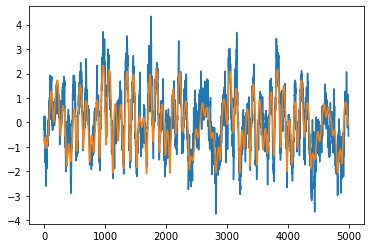

In [5]:
%matplotlib inline
plt.plot(times, y)
plt.plot(times, y_model)

## ETP

In [4]:
ecc = pd.read_csv("ETP/eccentricity.csv")
prec = pd.read_csv("ETP/precession.csv")
obl = pd.read_csv("ETP/obliquity.csv")

ETP = np.zeros((4, 10001))
ETP[0] = ecc["x"]
ETP[1] = ecc["y"]
ETP[2] = obl["y"]
ETP[3] = prec["y"]

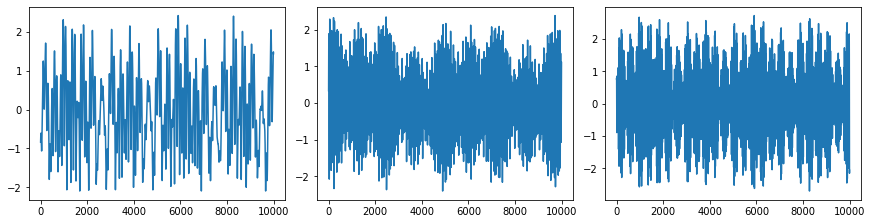

In [5]:
%matplotlib inline
fig, axs = plt.subplots(1,3,figsize=(12,3), constrained_layout=True)
axs[0].plot(ETP[0], ETP[1])
axs[1].plot(ETP[0], ETP[2])
axs[2].plot(ETP[0], ETP[3])

In [6]:
i_t0 = 0; i_tf = 2000
times = ETP[0,i_t0:i_tf]
times_true = times
alpha = 0.5
y_model = ETP[1,i_t0:i_tf]*1+ ETP[3,i_t0:i_tf]*1
N_data = len(y_model)
sigma_true = 1.4
rho_true = 0.7

white_noise = np.random.randn(N_data)*sigma_true
arparams = np.array([rho_true])
ar = np.r_[1, -arparams] # add zero-lag and negate
arma_process = sm.tsa.ArmaProcess(ar)
red_noise = arma_process.generate_sample(N_data)
red_noise = red_noise*np.sqrt(1-rho_true**2)*sigma_true
noise = red_noise

y = y_model + noise

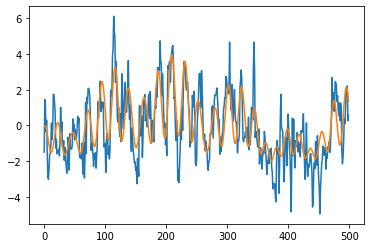

In [8]:
plt.figure()
plt.plot(times, y)
plt.plot(times, y_model)


# Envelope

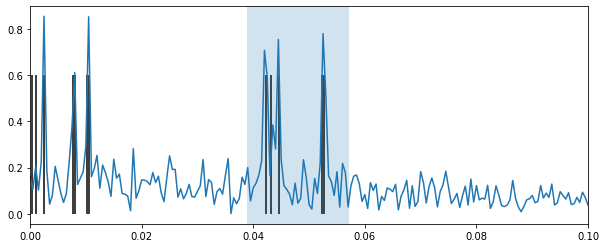

In [171]:
ydata_sp = CubicSpline(times_true, y)
times_grid = np.linspace(times_true[0], times_true[-1], len(times_true))
N = len(times_grid)
y_equ_spa = ydata_sp(times_grid)

dt = times_grid[1]-times_grid[0]
xf = sp.fft.fftfreq(N, dt)[:N//2]
yf = sp.fft.fft(y_equ_spa)

plt.figure(figsize=(10,4))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
# plt.yscale("log")
# plt.xscale("log")
plt.vlines(fs/2/np.pi, 0, 0.6, colors="black",alpha=1,zorder=-100)
plt.xlim([0,0.1])
# plt.xlim([0.04,0.06])
window_filter = [p0/2/np.pi, (p0+g_k[3]+g_k[0] )/2/np.pi]
plt.axvspan(*window_filter,alpha=0.2)
# plt.vlines(fs[:5]/2/np.pi, 0, 0.6, colors="orange", alpha=0.8)
# plt.xlim([0.03,0.1])
# plt.xlim([0,0.025])
# plt.xlim([50,500])
# plt.xlim([10,50])

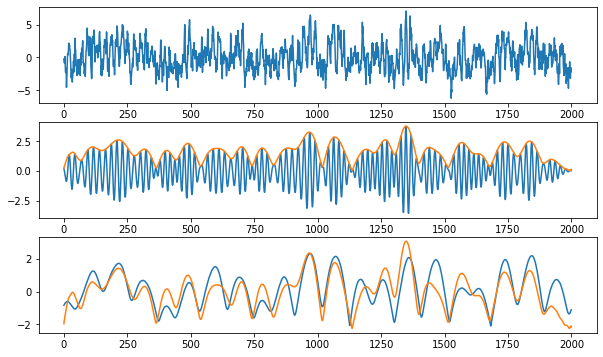

In [173]:
window_filter = [p0/2/np.pi, (p0+g_k[3]+g_k[0] )/2/np.pi]
sos = sp.signal.butter(10, window_filter, 'bandpass', output='sos' , fs=1/(times_grid[1]-times_grid[0]))
y_filtered = sp.signal.sosfiltfilt(sos, y_equ_spa)
complex_y = sp.signal.hilbert(y_filtered)
y_envelope =abs(complex_y)

plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(times_grid, y_equ_spa)
plt.subplot(3,1,2)
plt.plot(times_grid, y_filtered)
plt.plot(times_grid, abs(complex_y))
plt.subplot(3,1,3)
# plt.plot(times, y_ecc)
plt.plot(times_true, ETP[1,i_t0:i_tf])

plt.plot(times_grid, (y_envelope-y_envelope.mean())/y_envelope.std())
# filtered = signal.sosfilt(sos, sig )



# Model

In [32]:
coef_time = 1e3
arcsec_to_pi = 1/180/3600*np.pi


b_k = np.array([0.018986, 0.016354, 0.013055, 0.008849, 0.004248])/0.022 #
muy_k = np.array([4.257564, 7.456665, 17.910194, 17.366595, 5.579378])
phi_k = np.array([30.739, -157.801, 140.577, -55.885, 77.107])
phi_k = phi_k/180/3600*np.pi
muy_k = muy_k/180/3600*np.pi*coef_time

p0 = 50.467718
# p0 = 40
p0 = p0/180/3600*np.pi*coef_time

# b_k

ordering = [4, 1, 3, 2, 0]
b_k = b_k[ordering]
g_k = muy_k[ordering]
phi_k = phi_k[ordering]


# fe_k = np.array([3.199279, 13.651920, 10.456224, 13.109803, 9.909679])
# fe_k = fe_k/180/3600*np.pi*coef_time

fe_k =  np.array([g_k[1]-g_k[4], g_k[3]-g_k[4] , g_k[3]-g_k[1], g_k[2]-g_k[4], g_k[2]-g_k[1], g_k[3]-g_k[2], g_k[0]-g_k[4]])

fs = np.hstack([g_k + p0, fe_k])
print(fs)
print(2*np.pi/fs)

[0.27172399 0.28082533 0.32887003 0.33150547 0.26531565 0.01550968
 0.06618982 0.05068014 0.06355438 0.0480447  0.00263544 0.00640834]
[  23.12341035   22.37399749   19.10537518   18.95348896   23.68192456
  405.11381166   94.92676503  123.97727122   98.86314252  130.7779167
 2384.11034605  980.47077728]


In [ ]:
g_k[3]-g_k[2], g_k

## When time is known

In [12]:
reg = linear_model.LinearRegression()
X = generate_X_linReg(np.ones_like(fe_k), fe_k, times)
X = generate_X_linReg(np.ones_like(fs), fs, times)

# reg.fit(X, y)
reg.fit(X, y_model)

y_pred = reg.predict(X)
# y_true = X @ ABtrue
# y_pred = X @ reg.coef_

0.9920285336431623 0.5055549010218239


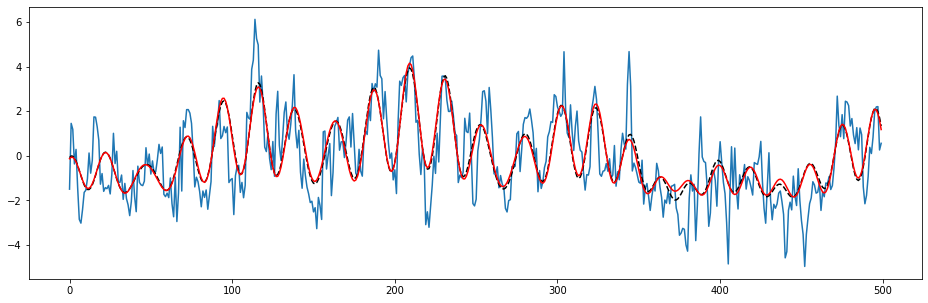

In [13]:
%matplotlib inline
plt.figure(figsize=(16,5))
plt.plot(times, y)
plt.plot(times, y_model, "--", color="black")
plt.plot(times, y_pred, color="red")
print(r2_score(y_model, y_pred), r2_score(y, y_pred))
# plt.xlim([2500,3000])

In [20]:
i_t0 = 0; i_tf = 10000
N_data = len(ETP[0])
sigma_true = 1*np.sqrt(2)
rho_true = 0.7

white_noise = np.random.randn(N_data)*sigma_true
arparams = np.array([rho_true])
ar = np.r_[1, -arparams] # add zero-lag and negate
arma_process = sm.tsa.ArmaProcess(ar)
red_noise = arma_process.generate_sample(N_data)
red_noise = red_noise*np.sqrt(1-rho_true**2)*sigma_true
noise = red_noise

# y = y_model + noise

In [26]:
i_t0 = 0
# i_tfs = np.array([1000*i for i in range(1,11) ])
i_tfs = np.arange(1000, 10001, 100)
r2s = np.zeros_like(i_tfs, dtype=float)
r2s_noise = np.zeros_like(i_tfs, dtype=float)

for i, i_tf in enumerate(i_tfs):
    times = ETP[0,i_t0:i_tf]
    y_model = ETP[1,i_t0:i_tf]*1+ ETP[3,i_t0:i_tf]*1
    X = generate_X_linReg(np.ones_like(fs), fs, times)
    # X = generate_X_linReg(np.ones_like(fe_k[:]), fe_k[:], times)
    reg = linear_model.LinearRegression()

    reg.fit(X, y_model)
    y_pred = reg.predict(X)
    r2s[i] = r2_score(y_model, y_pred)
    
    y = y_model + noise[i_t0:i_tf]
    reg.fit(X, y)
    y_pred = reg.predict(X)
    r2s_noise[i] = r2_score(y_model, y_pred)

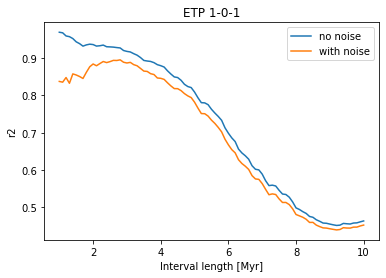

In [27]:
fig  = plt.figure()
plt.plot((i_tfs-i_t0)/1e3, r2s, label="no noise")
plt.plot((i_tfs-i_t0)/1e3, r2s_noise,label="with noise")
plt.title("ETP 1-0-1")
plt.xlabel("Interval length [Myr]")
plt.ylabel("r2")
plt.legend()

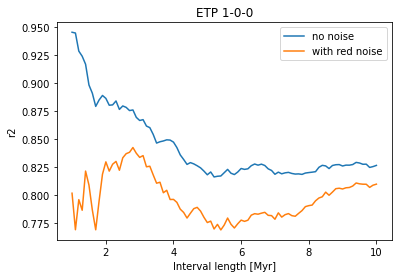

In [23]:
fig  = plt.figure()
plt.plot((i_tfs-i_t0)/1e3, r2s, label="no noise")
plt.plot((i_tfs-i_t0)/1e3, r2s_noise,label="with red noise")
plt.title("ETP 1-0-0")
plt.xlabel("Interval length [Myr]")
plt.ylabel("r2")
plt.legend()

## Age model and noise

In [123]:
i_t0 = 0; i_tf = 3000
times = ETP[0,i_t0:i_tf]
alpha = 0.5
y_ecc = ETP[1,i_t0:i_tf]
y_prec = ETP[3,i_t0:i_tf]
y_model = y_ecc*1+ y_prec*1

Text(0, 0.5, 'time [kyr]')

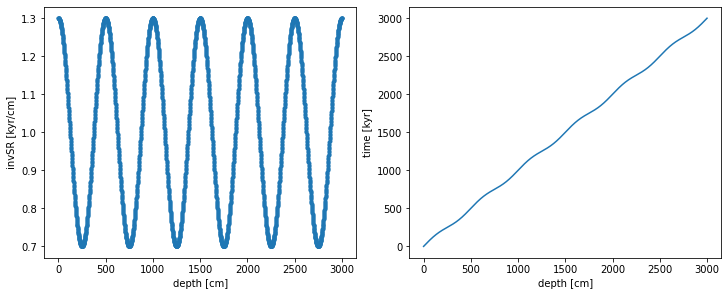

In [124]:
%matplotlib inline
y_sp = CubicSpline(times, y_model)

depth = times*1 # 1 cm/1kyr average

func_inv_SR = partial(sine_inverse_SR, A=0.3, k= 4*1e-3)
# func_inv_SR = partial(linear_inverse_SR, a=-1.2)
# func_inv_SR = partial(logistic_inverse_SR, A=0.4, k=50)
# func_inv_SR = partial(heart_wave_inverse_SR, A=0.2, k=2)
# func_inv_SR = constant_inverse_SR
invSR = func_inv_SR(depth)
times_true = sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)

plt.figure(constrained_layout=True,figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(depth, invSR, '.')
plt.xlabel("depth [cm]")
plt.ylabel("invSR [kyr/cm]")

plt.subplot(1,2,2)
plt.plot(depth, times_true)
plt.xlabel("depth [cm]")
plt.ylabel("time [kyr]")
# x = np.linspace(times[0],times[-1],1000000)
# y = sp(x)
# plt.plot(times,y_model,'.')
# plt.plot(x,y)


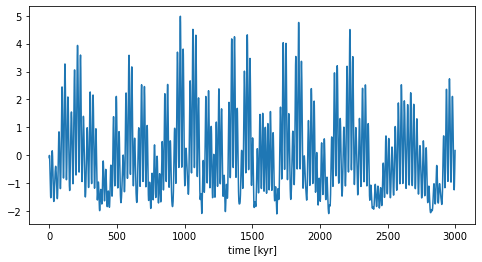

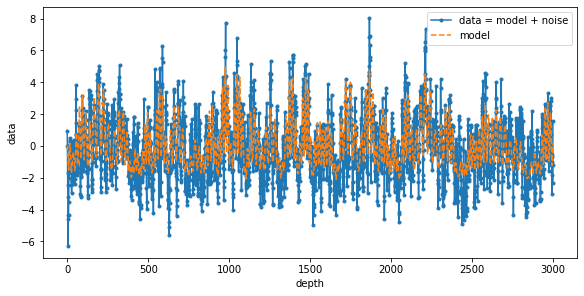

In [135]:

np.random.seed(3)

y_model = y_sp(times_true)
N_data = len(y_model)
sigma_true = 1*np.sqrt(2)
rho_true = 0.7

white_noise = np.random.randn(N_data)*sigma_true
arparams = np.array([rho_true])
ar = np.r_[1, -arparams] # add zero-lag and negate
arma_process = sm.tsa.ArmaProcess(ar)
red_noise = arma_process.generate_sample(N_data)
red_noise = red_noise*np.sqrt(1-rho_true**2)*sigma_true
noise = red_noise

y = y_model + noise
plt.figure(figsize=(8,4))
plt.plot(times_true, y_model)
plt.xlabel("time [kyr]")

plt.figure(figsize=(8,4), constrained_layout=True)
plt.plot(depth, y, '.-', label="data = model + noise")
plt.plot(depth, y_model,'--', label="model")
plt.xlabel("depth")
plt.ylabel("data")
plt.legend()

(0.0, 0.1)

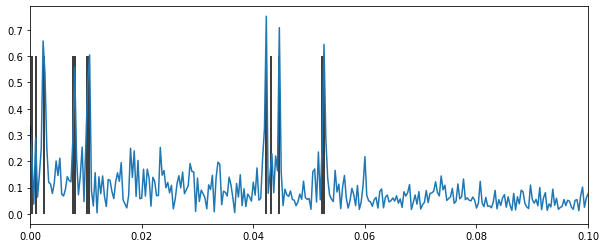

In [12]:
ydata_sp = CubicSpline(times_true, y)
times_grid = np.linspace(times_true[0], times_true[-1], len(times_true))
N = len(times_grid)
y_equ_spa = ydata_sp(times_grid)

dt = times_grid[1]-times_grid[0]
xf = sp.fft.fftfreq(N, dt)[:N//2]
yf = sp.fft.fft(y_equ_spa)

plt.figure(figsize=(10,4))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
# plt.yscale("log")
# plt.xscale("log")
plt.vlines(fs/2/np.pi, 0, 0.6, colors="black",alpha=1,zorder=-1)
plt.xlim([0,0.1])
# plt.xlim([0.04,0.06])

# plt.vlines(fs[:5]/2/np.pi, 0, 0.6, colors="orange", alpha=0.8)
# plt.xlim([0.03,0.1])
# plt.xlim([0,0.025])
# plt.xlim([50,500])
# plt.xlim([10,50])

### Best case sceranio

In [103]:
2*np.pi/fs

array([  22.9170533 ,   22.18074355,   18.96428374,   18.81462377,
         23.46552522,  405.11381166,   94.92676503,  123.97727122,
         98.86314252,  130.7779167 , 2384.11034605,  980.47077728])

In [96]:
reg = linear_model.LinearRegression()
# X = generate_X_linReg(np.ones_like(fe_k), fe_k, times_true)

fs = np.hstack([g_k + p0*1.01, fe_k])


depth_genes = np.linspace(depth[0], depth[-1], 20)
func_inv_SR(depth_genes)
timesx = sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)

X = generate_X_linReg(np.ones_like(fs), fs, times_true)
# X = generate_X_linReg(np.ones_like(fs), fs, timesx)

reg.fit(X, y)
# reg.fit(X, y_model)

y_pred = reg.predict(X)
print(r2_score(y_model, y_pred))
# y_true = X @ ABtrue
# y_pred = X @ reg.coef_

0.5276663378563968


0.5276663378563968 0.3989649381968896


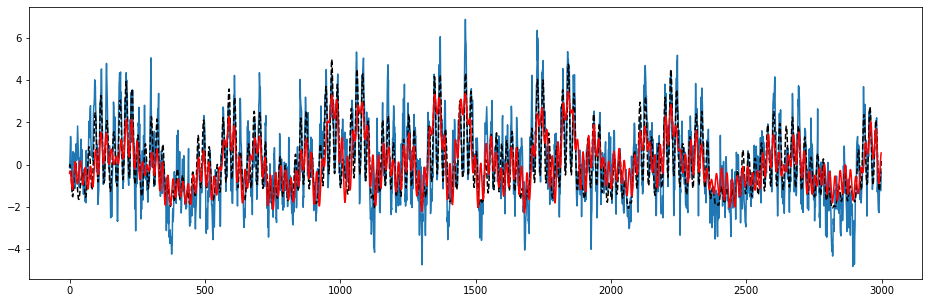

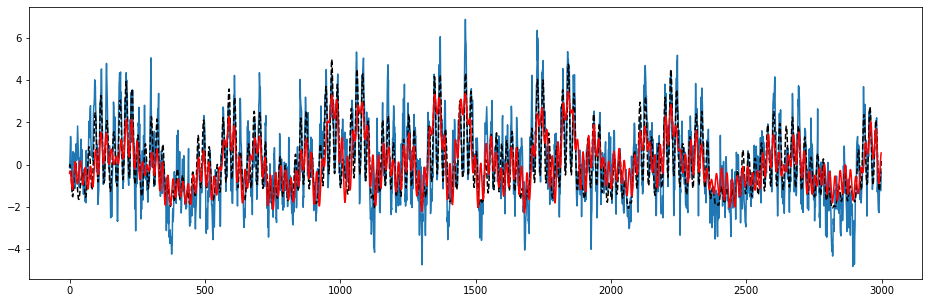

In [100]:
%matplotlib inline
plt.figure(figsize=(16,5))
plt.plot(times_true, y)
plt.plot(times_true, y_model, "--", color="black")
plt.plot(times_true, y_pred, color="red")
print(r2_score(y_model, y_pred), r2_score(y, y_pred))


0.5345627905466688 0.3679357250360197


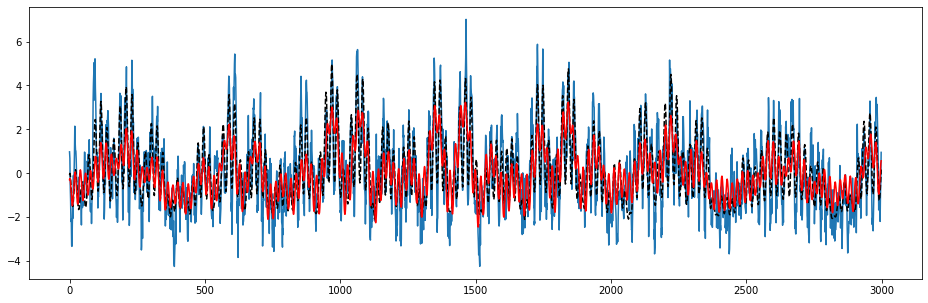

In [81]:
%matplotlib inline
plt.figure(figsize=(16,5))
plt.plot(times_true, y)
plt.plot(times_true, y_model, "--", color="black")
plt.plot(times_true, y_pred, color="red")
print(r2_score(y_model, y_pred), r2_score(y, y_pred))

In [103]:
# ABs = reg.coef_
amp = np.sqrt(reg.coef_[:len(fs)]**2 + reg.coef_[len(fs):]**2)
plt.plot(2*np.pi/fs, amp,'.')
plt.xscale("log")

ValueError: operands could not be broadcast together with shapes (10,) (0,) 

In [112]:
p0_lims = np.array([40, 100])/180/3600*np.pi*coef_time
N_p0 = 1000
p0s = np.linspace(*p0_lims, N_p0)
r2s = np.zeros(N_p0)
for i, p0i in enumerate(p0s):

    reg = linear_model.LinearRegression()
    # X = generate_X_linReg(np.ones_like(fe_k), fe_k, times_true)

    fsx = np.hstack([g_k + p0i, fe_k])
    fsx = np.hstack([g_k + p0i])

    depth_genes = np.linspace(depth[0], depth[-1], 20)
    func_inv_SR(depth_genes)
    timesx = sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)

    X = generate_X_linReg(np.ones_like(fsx), fsx, times_true)
    # X = generate_X_linReg(np.ones_like(fs), fs, timesx)

    reg.fit(X, y)
    # reg.fit(X, y_model)

    y_pred = reg.predict(X)
    r2s[i]  = r2_score(y, y_pred)
# y_true = X @ ABtrue
# y_pred = X @ reg.coef_

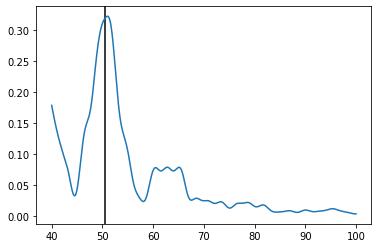

In [113]:
plt.plot(p0s/(1/180/3600*np.pi*coef_time), r2s)
plt.axvline(p0/(1/180/3600*np.pi*coef_time), color="black",zorder=-10)
# plt.xlim([0.23, 0.3])

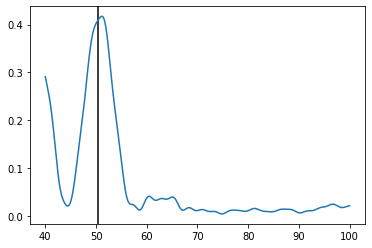

In [88]:
plt.plot(p0s/(1/180/3600*np.pi*coef_time), r2s)
plt.axvline(p0/(1/180/3600*np.pi*coef_time), color="black",zorder=-10)
# plt.xlim([0.23, 0.3])

# GA

## search for optimal length of genes

In [15]:
a = 1/180/3600*np.pi*coef_time
p0/a, p0,p0*2

(50.467718, 0.24467440140777985, 0.4893488028155597)

In [19]:
# N_population = 128 # number of individual in population 
# N_generations_max = 100
N_genes = 22 # number of intial gene in an individial of the population 
depth_lims = depth[0], depth[-1]
depth_genes = np.linspace(*depth_lims, N_genes)
true_genes = func_inv_SR(depth_genes)
invSR_lims = [0, 2]
fs = np.hstack([g_k + p0, fe_k])
# fs =  np.array([f1, f2])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
n_pieces = 2
metric_optimal = metric_piecewise([depth_genes, func_inv_SR(depth_genes)], [depth, y], fs, interpolator, n_pieces)
print(metric_optimal, metric_optimal.mean())
# invSR_all = np.zeros((N_generations_max, N_population, N_genes))
# invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
# invSR_all[0] = invSR_ini
# metric_all = np.zeros((N_generations_max, N_population))
# metric_ini = np.array([metric([depth_genes, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
# metric_all[0] = metric_ini
interpolator = interpolate_CubicSpline
data = [depth, y]
problem = invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=n_pieces, metric=metric_piecewise)
out = {}
problem._evaluate(func_inv_SR(depth_genes), out)
out

[0.65740439 0.5788564 ] 0.6181303932977957


{'F': array([-0.65740439, -0.5788564 ])}

In [ ]:
algorithm = NSGA2(
    pop_size=200,
    # n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
N_generations = 200
termination = get_termination("n_gen", N_generations)

# N_genes_enemble = np.arange(10, 60, 4)
# N_genes_enemble = np.array([24]*10)
# depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1], N_genes) for N_genes in N_genes_enemble] 
# N_ensemble = len(depth_genes_ensemble)

N_trial = 4
N_genes_distinct = np.arange(2, 60, 2)
N_genes_enemble = np.array([ np.array([i]*N_trial)  for i in  N_genes_distinct]).flatten()
depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1],N_genes) for N_genes in N_genes_enemble] 

N_ensemble = len(depth_genes_ensemble)


problems = [invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=2, metric=metric_piecewise) for depth_genes in depth_genes_ensemble  ] 


res_ensemble = Parallel(n_jobs=N_ensemble, verbose=100)(delayed(minimize)(problem, algorithm, termination, 
                                                                          save_history=False, callback=Callback_getF())
                                                        for problem in problems)

In [ ]:
# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(10,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
plt.subplot(1,2,1)

cmap = plt.get_cmap("rainbow")

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])

    # opt_max_ensemble[i] = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

    # plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
    plt.plot(opt_max_ensemble[i], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))


metric_optimal = metric_piecewise([depth, func_inv_SR(depth)], [depth, y], fs, interpolator, n_pieces)
plt.ylabel("r2")
plt.xlabel("number of generations")
plt.ylim([0.1, 0.8])
plt.axhline(metric_optimal.mean(), color="k")

# plt.yscale("log")
plt.subplot(1,2,2)
# ax2 = fig.add_subplot(gs1[0, 1])

# plt.plot(N_genes_enemble, opt_max_ensemble[:,-1], '.-')
# [ for i in range(N_ensemble)]
for i in range(N_ensemble):
    plt.scatter(N_genes_enemble[i], opt_max_ensemble[i,-1], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
    # metric_optimal = metric_piecewise([depth_genes_ensemble[i], func_inv_SR(depth_genes_ensemble[i])], [depth, y], fs, interpolator, n_pieces)
    # plt.axhline(metric_optimal.mean() , color=cmap(i/N_ensemble),zorder=-10)
plt.axhline(metric_optimal.mean(), color="k")

plt.xlabel("number of genes")
plt.ylabel("r2")
plt.ylim([0.1, 0.8])
# plt.savefig("r2_Ngenesb.png", dpi=200)

In [ ]:
%matplotlib inline
plt.figure(figsize=(7, 5))
for i in range(N_ensemble):
    res = res_ensemble[i]
    plt.scatter(-res.F[:, 0], -res.F[:, 1], s=30, facecolors='none', color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
f1min, f1max = -res.F[:,0].min(), -res.F[:,1].max()
f1grid = np.linspace(0, 1, 100)

# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()


In [ ]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_inv_SR(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")

for i, res in enumerate(res_ensemble):
    # if i<=2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    ax.plot(depth, interpolator([depth_genes, res.X[arg_best,:]], depth), color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best], '.', color=cmap(i/N_ensemble))




fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_inv_SR(depth),color="black")
i = 34
res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]
print(len(depth_genes))
arg_best = np.argmin(res.F.mean(axis=1))
print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best], '.', color="black")
# ax.set_ylim(invSR_lims)

# fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))

# time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])
# ax.plot(depth, y )
# ax.plot(depth, y_pred, color="black")

# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

## got it

In [16]:
# N_population = 128 # number of individual in population 
# N_generations_max = 100
N_genes = 20 # number of intial gene in an individial of the population 
depth_lims = depth[0], depth[-1]
depth_genes = np.linspace(*depth_lims, N_genes)
true_genes = func_inv_SR(depth_genes)
invSR_lims = [0, 2]
fs = np.hstack([g_k + p0, fe_k])
# fs =  np.array([f1, f2])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
n_pieces = 2
metric_optimal = metric_piecewise([depth_genes, func_inv_SR(depth_genes)], [depth, y], fs, interpolator, n_pieces)
print(metric_optimal)

interpolator = interpolate_CubicSpline
data = [depth, y]
problem = invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=n_pieces, metric=metric_piecewise)
out = {}
problem._evaluate(func_inv_SR(depth_genes), out)
out

[0.61782791 0.54564135]


{'F': array([-0.61782791, -0.54564135])}

In [21]:
algorithm = NSGA2(
    pop_size=200,
    # n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
N_generations = 400
termination = get_termination("n_gen", N_generations)

# N_genes_enemble = np.arange(10, 60, 4)
N_genes_enemble = np.array([20]*64)
depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1], N_genes) for N_genes in N_genes_enemble] 
N_ensemble = len(depth_genes_ensemble)

# N_trial = 4
# N_genes_distinct = np.arange(2, 60, 2)
# N_genes_enemble = np.array([ np.array([i]*N_trial)  for i in  N_genes_distinct]).flatten()
# depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1],N_genes) for N_genes in N_genes_enemble] 

# N_ensemble = len(depth_genes_ensemble)


problems = [invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=2, metric=metric_piecewise) for depth_genes in depth_genes_ensemble  ] 


res_ensemble = Parallel(n_jobs=len(problems), verbose=100)(delayed(minimize)(problem, algorithm, termination, 
                                                                          save_history=False, callback=Callback_getF())
                                                        for problem in problems)

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])
ind_sort = np.argsort(opt_max_ensemble[:,-1])
res_ensemble = [res_ensemble[i] for i in  ind_sort]
opt_max_ensemble = opt_max_ensemble[ind_sort]

[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:   49.2s
[Parallel(n_jobs=64)]: Done   2 out of  64 | elapsed:   49.2s remaining: 25.4min
[Parallel(n_jobs=64)]: Done   3 out of  64 | elapsed:   49.2s remaining: 16.7min
[Parallel(n_jobs=64)]: Done   4 out of  64 | elapsed:   49.2s remaining: 12.3min
[Parallel(n_jobs=64)]: Done   5 out of  64 | elapsed:   49.2s remaining:  9.7min
[Parallel(n_jobs=64)]: Done   6 out of  64 | elapsed:   49.2s remaining:  7.9min
[Parallel(n_jobs=64)]: Done   7 out of  64 | elapsed:   49.2s remaining:  6.7min
[Parallel(n_jobs=64)]: Done   8 out of  64 | elapsed:   49.2s remaining:  5.7min
[Parallel(n_jobs=64)]: Done   9 out of  64 | elapsed:   49.2s remaining:  5.0min
[Parallel(n_jobs=64)]: Done  10 out of  64 | elapsed:   49.2s remaining:  4.4min
[Parallel(n_jobs=64)]: Done  11 out of  64 | elapsed:   49.2s remaining:  3.9min
[Parallel(n_jobs=64)]: Done  12 out of  64 | elapse

KeyboardInterrupt: 

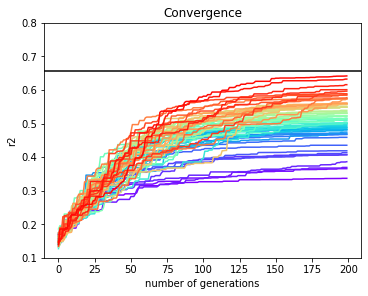

In [345]:

# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(5,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
plt.subplot(1,1,1)

cmap = plt.get_cmap("rainbow")

for i in range(N_ensemble):

    plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))


metric_optimal = metric_piecewise([depth, func_inv_SR(depth)], [depth, y], fs, interpolator, n_pieces)
plt.ylabel("r2")
plt.xlabel("number of generations")
plt.ylim([0.1, 0.8])
plt.axhline(metric_optimal.mean(), color="k")


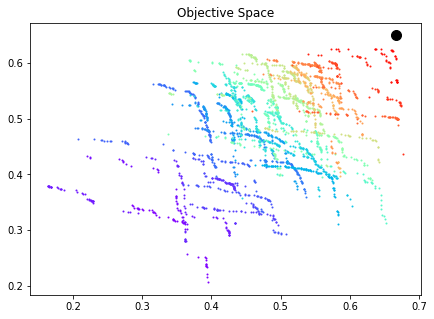

In [344]:
%matplotlib inline
plt.figure(figsize=(7, 5))
metric_optimal = metric_piecewise([depth, func_inv_SR(depth)], [depth, y], fs, interpolator, n_pieces)

for i in range(N_ensemble):
    res = res_ensemble[i]
    plt.scatter(-res.F[:, 0], -res.F[:, 1], s=1, color=cmap(i/N_ensemble))
f1min, f1max = -res.F[:,0].min(), -res.F[:,1].max()
f1grid = np.linspace(0, 1, 100)
plt.scatter(*metric_optimal, s=100, marker='o', color="black")
# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()


In [ ]:
times_true

ValueError: The length of `y` along `axis`=0 doesn't match the length of `x`

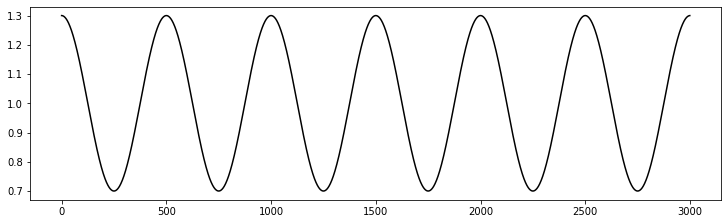

In [371]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_inv_SR(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")
invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)

for i, res in enumerate(res_ensemble):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    ax.plot(depth, interpolator([depth_genes, res.X[arg_best,:]], depth), color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best], '.', color=cmap(i/N_ensemble))

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
for i, res in enumerate(res_ensemble):
# for i, res in enumerate(reversed(res_ensemble)):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best]])
    axs[0].plot(depth, time, color=cmap(i/N_ensemble))
    axs[1].plot(depth, time-times_true, color=cmap(i/N_ensemble))
axs[0].plot(depth, times_true, color="black")
axs[1].plot(depth, depth*0, color="k")

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_inv_SR(depth),color="black")
# i = -15
i = -1

res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]
arg_best = np.argmin(res.F.mean(axis=1))
print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best], '.', color="black")
# ax.set_ylim(invSR_lims)
# print(res.X[arg_best,0])
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))

time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best]])
ax.plot(depth, y )
ax.plot(depth, y_model, "--",color="black")
ax.plot(depth, y_pred, color="red")
print(r2_score(y, y_pred))
# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

In [354]:
1+1

2

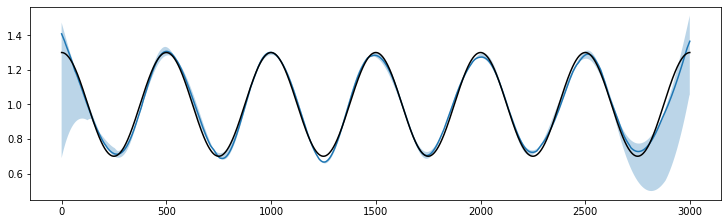

In [360]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
N_indi = 7
# ind_sort = np.argsort(-opt_max_ensemble[:,-1])
# res_ensemblex = [res_ensemble[i] for i in  ind_sort[:10]]
res_ensemblex = res_ensemble[-3:]
invSR_pop = np.zeros([len(depth), len(res_ensemblex), N_indi])
# res_ensemble_x = res_ensemble[10:]
for i, res in enumerate(res_ensemblex):
    # if i<10:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    for j in range(N_indi):
        # arg_best = np.argmin(res.F.sum(axis=1))
        invSR_pop[:, i, j] = interpolator([depth_genes, res.X[j]], depth)
        # ax.plot(depth, interpolator([depth_genes, res.X[j]], depth), color="black",alpha=0.1)
        # ax.plot(depth_genes, res.X[j], '.', alpha=0.1, color="black")
# invSR_pop = invSR_pop[:,40:]
invSR_pop = invSR_pop.reshape(len(depth), -1)
# ax.fill_between(depth, *np.quantile(invSR_pop, [0.25, 0.75], axis=-1), alpha=0.3)
ax.fill_between(depth, *np.quantile(invSR_pop, [0.1, 0.9], axis=-1), alpha=0.3)
ax.plot(depth, np.median(invSR_pop,axis=-1))

ax.plot(depth, func_inv_SR(depth),color="black",zorder=100)


# MCMC

In [37]:
def loglike_wrapper(func, depth_genes):
    def wrap(x, *args, **kwargs):
        result = func([depth_genes, x], *args, **kwargs)
        return result
    return wrap

In [278]:
# %lprun -f log_likelihood_rednoise  log_likelihood_rednoise([depth_genes, invSR_best], data=[depth, y],interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims,  fs=fs, noise_params=[sigma_true, rho_true])         

In [279]:
%timeit  log_likelihood_rednoise([depth_genes, invSR_best], data=[depth, y],interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims,  fs=fs, noise_params=[sigma_true, rho_true])         

4.9 ms ± 351 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [280]:
5*1e-3*10*50

2.5

In [42]:
res = res_ensemble[-1]
N_genes = res.X.shape[1]
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]
invSR_random = np.random.randn(N_genes)*(invSR_lims[1]-invSR_lims[0]) + invSR_lims[0]

nwalkers = 40
n_temps = 5
# params_noise_ini = [0.7, 0.7]
# params_noise_ini = [0.7]
params_noise_ini = []
ndim = N_genes+len(params_noise_ini)
params_ini = np.hstack([params_noise_ini, invSR_best])
pos = params_ini + 1e-4 * np.random.randn(n_temps, nwalkers, N_genes+len(params_noise_ini))
pos = params_ini + 1e-4 * np.random.randn(nwalkers, N_genes+len(params_noise_ini))

pos = list(pos)
# pos = invSR_random + 1e-4 * np.random.randn(nwalkers, N_genes)
params_best = np.hstack([sigma_true, rho_true, func_inv_SR(depth_genes)])

# nwalkers, ndim = pos.shape
# log_posterior = log_posterior_whitenoise
# log_posterior = log_posterior_rednoise_v1
# log_probability_testcase = partial(log_posterior, depth_invSR=depth_genes, data=[depth, y], fs=fs, interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims) 
log_posterior = log_posterior_whitenoise_v0
log_probability_testcase = partial(log_posterior, depth_invSR=depth_genes, data=[depth, y], fs=fs, interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims, sigma=0.7) 

logl = partial(log_likelihood_rednoise,  data=[depth, y], fs=fs, noise_params=[sigma_true, rho_true], interpolator=interpolate_CubicSpline) 
# logl = partial(log_likelihood_whitenoise,  data=[depth, y], fs=fs, sigma=sigma_true, interpolator=interpolate_CubicSpline) 

logl([depth_genes, func_inv_SR(depth_genes)])
logl = loglike_wrapper(logl, depth_genes)
# lp(func_inv_SR(depth_genes))
logp = partial(log_uniform, x_lims=invSR_lims)

# with Pool(processes=1) as pool:
with Pool(processes=1) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_testcase, pool=pool)
    # sampler = reddemcee.PTSampler(nwalkers, ndim, logl, logp)
    sampler.run_mcmc(pos, 100, progress=True)
    # print("Multiprocessing took {0:.1f} seconds".format(multi_time))

 43%|████▎     | 43/100 [00:11<00:14,  3.91it/s]


KeyboardInterrupt: 

In [294]:
samples = np.array([ptsampler.get_chain() for ptsampler in sampler.sampler ])
samples.shape

(5, 1000, 40, 20)

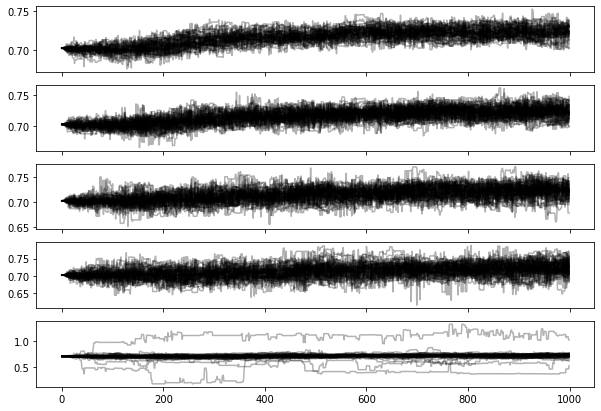

In [363]:
fig, axes = plt.subplots(n_temps, figsize=(10, 7), sharex=True)
samples = np.array([ptsampler.get_chain() for ptsampler in sampler.sampler ])
# logprob_sample = sampler.get_log_prob()

# labels = ["m", "b", "log(f)"]
for i in range(n_temps):
    ax = axes[i]
    [ax.plot(samples[i,:, j, 5], "k", alpha=0.3) for j in range(40) ]
    # ax.set_xlim(0, len(samples))
    # ax.axhline(params_best[i], ls="--", color="red")
    # ax.set_ylabel(labels[i])
    # ax.yaxis.set_label_coords(-0.1, 0.5)


# axes[-1].plot(logprob_sample, "k", alpha=0.3)
# axes[-1].axhline(logl(params_best), ls="--", color="red")
# axes[-1].set_xlabel("step number");     

(640, 20)


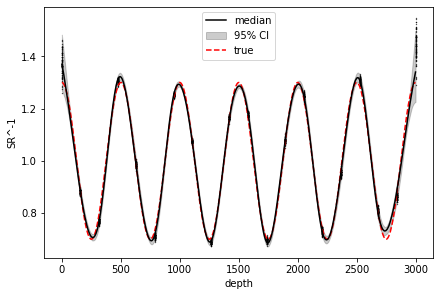

In [328]:
%matplotlib inline
flat_samples = sampler.sampler[0].get_chain(discard=200, thin=50, flat=True)
print(flat_samples.shape)
inds = np.random.randint(len(flat_samples), size=1000)
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i,len(params_noise_ini):]], depth) for i in inds])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.025, 0.975],axis=0)
# invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.005, 0.995],axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="median")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black", label="95% CI")

# plt.plot(depth, best_invSR, "--",color="black", label="best", zorder=10)
for i in range(100):
    plt.scatter(depth_genes, flat_samples[i,len(params_noise_ini):], s=0.1, color="black")
plt.plot(depth, invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
# plt.savefig("figures/invSR_sinek10.png")

(640, 20)


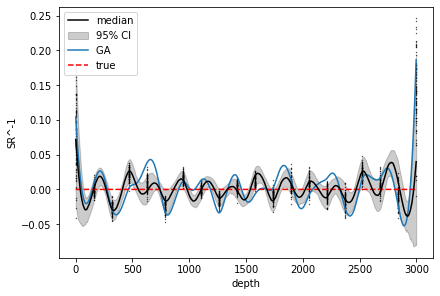

In [341]:
%matplotlib inline
flat_samples = sampler.sampler[0].get_chain(discard=200, thin=50, flat=True)
print(flat_samples.shape)
inds = np.random.randint(len(flat_samples), size=1000)
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i,len(params_noise_ini):]], depth) for i in inds])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.025, 0.975],axis=0)
# invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.005, 0.995],axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR-invSR, zorder=10,color="black", label="median")
# plt.plot(depth, mean_invSR-invSR, zorder=10,color="black", label="median")invSR_best
plt.fill_between(depth, invSR_lo-invSR, invSR_up-invSR, alpha=0.2, color="black", label="95% CI")
plt.plot(depth, interpolator([depth_genes, invSR_best], depth)-invSR,label="GA ")
# plt.plot(depth, best_invSR, "--",color="black", label="best", zorder=10)
for i in range(100):
    plt.scatter(depth_genes, flat_samples[i,len(params_noise_ini):]-func_inv_SR(depth_genes), s=0.1, color="black")
# plt.plot(depth_genes, invSR_best-func_inv_SR(depth_genes),'.')
plt.plot(depth, invSR-invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
# plt.savefig("figures/invSR_sinek10.png")

## Frequencies

In [346]:
prior_params_freq = np.array([[50, 10], [5.525, 0.125], [7.455, 0.015], [17.3, 0.15], [17.85, 0.15], [4.257564, 0.00002]])
prior_params_freq = prior_params_freq/180/3600*np.pi*coef_time

In [349]:
log_posterior = log_posterior_whitenoise_EP
log_posterior = log_posterior_rednoise_EP
res = res_ensemble[-1]
arg_best = np.argmin(res.F.sum(axis=1)/2)
# invSR_best = res.X[arg_best]
invSR_best = res.X[arg_best,1:]

invSR_random = np.random.randn(N_genes)*(invSR_lims[1]-invSR_lims[0]) + invSR_lims[0]

nwalkers = 60
params_noise_ini = [0.7, 0.7]
params_freq_ini = prior_params_freq[:,0].copy()
params_freq_ini[0] = res.X[arg_best,0]
params_ini = np.hstack([params_noise_ini, params_freq_ini, invSR_best])
params_best = np.hstack([sigma_true, rho_true, p0, muy_k, true_genes])
pos_ini = params_ini + 1e-4 * np.random.randn(nwalkers, len(params_ini))
# pos = invSR_random + 1e-4 * np.random.randn(nwalkers, N_genes)

nwalkers, ndim = pos_ini.shape
log_probability_testcase = partial(log_posterior, depth_invSR=depth_genes, data=[depth, y],interpolator=interpolate_CubicSpline,
                                   invSR_lims=invSR_lims, sigma_lims=[1e-4, 2], prior_freq=prior_params_freq) 

print(f"log posterior initial point: {log_probability_testcase(pos_ini[0])}")
# print(f"log posterior best point: {log_probability_testcase(params_best)}")


with Pool(processes=1) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_testcase, pool=pool)
    sampler.run_mcmc(pos_ini, 2000, progress=True)


log posterior initial point: -2338414.388201799


100%|██████████| 2000/2000 [14:04<00:00,  2.37it/s]


In [289]:
print("acceptance_fraction", sampler.acceptance_fraction.mean())
tau = sampler.get_autocorr_time()
print("autocorr_time",tau)

acceptance_fraction 0.29250833333333337


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 27 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [273.09980606 220.62112528 237.55940781 126.19836424 162.05100965
 221.13674366 226.41811211  13.23792942 275.55315374 144.97295912
 177.65959035 160.51574225 134.3582755  182.79102899 178.42576227
 231.29059355 167.01456517 250.44828208 248.80249807 198.49113553
 248.90340828 146.52268572 206.08234402 264.82925912 147.86447061
 282.26091694 274.42680759 262.58840327]

In [290]:
params_ini, rho_true

(array([0.7       , 0.7       , 0.24293459, 0.02678596, 0.03614286,
        0.08387277, 0.08653924, 0.02064125, 1.18788926, 0.91661954,
        0.74702416, 1.33805352, 0.95019863, 0.75512112, 1.25289528,
        1.05943684, 0.71859015, 1.16844437, 1.17954668, 0.70419769,
        1.08377935, 1.24949418, 0.75126035, 0.85349926, 1.08814988,
        1.61778064, 0.37489449, 1.99953856]),
 0.7)

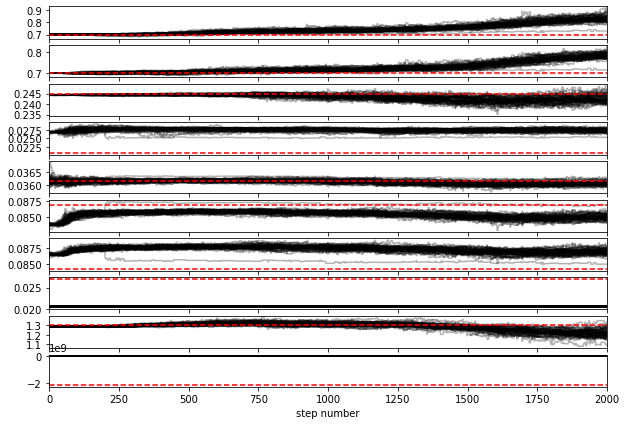

In [350]:
ndim = 10
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
logprob_sample = sampler.get_log_prob()

# labels = ["m", "b", "log(f)"]
for i in range(ndim-1):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.axhline(params_best[i], ls="--", color="red")
    # ax.set_ylabel(labels[i])
    # ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].plot(logprob_sample, "k", alpha=0.3)
axes[-1].axhline(log_probability_testcase(params_best), ls="--", color="red")
axes[-1].set_xlabel("step number");     

In [353]:
flat_samples = sampler.get_chain(discard=1500, thin=50, flat=True)

(45.0, 55.0)

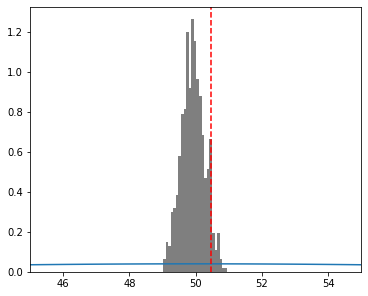

In [369]:
fig, ax = plt.subplots(1,1, figsize=(5,4),constrained_layout=True)
coef = 1/180/3600*np.pi*1e3

muy, sigma = prior_params_freq[0]/coef
x = np.linspace(muy - 3*sigma, muy + 3*sigma, 100)
freqs_0 = np.hstack([p0, g_k])/coef

ax.plot(x, sp.stats.norm.pdf(x, muy, sigma))
ax.hist(flat_samples[:,len(params_noise_ini)+0]/coef, density=True, color="k", alpha=0.5, bins=25)
ax.axvline(freqs_0[0], ls="--", color="red")
ax.set_xlim(45,55)

(45.0, 55.0)

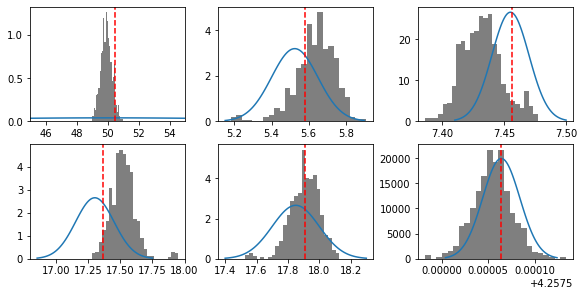

In [354]:
fig, axs = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
coef = 1/180/3600*np.pi*1e3
# coef=1
freqs_0 = np.hstack([p0, g_k])/coef
for i, ax in enumerate(axs.flatten()):

    # variance = 1
    # sigma = math.sqrt(variance)
    muy, sigma = prior_params_freq[i]/coef
    x = np.linspace(muy - 3*sigma, muy + 3*sigma, 100)
    ax.plot(x, sp.stats.norm.pdf(x, muy, sigma))
    ax.hist(flat_samples[:,len(params_noise_ini)+i]/coef, density=True, color="k", alpha=0.5, bins=25)
    ax.axvline(freqs_0[i], ls="--", color="red")
    # plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black", label="best")
    
    # ax.hist(2*np.pi/(flat_samples[:,1+i]+flat_samples[:,1])*1e3, density=True, color="k", alpha=0.5, bins=25)
    # ax.axvline(2*np.pi/fs[i-1]*1e3)
# axs[0,0].set_xlim(45,55)

(45.0, 55.0)

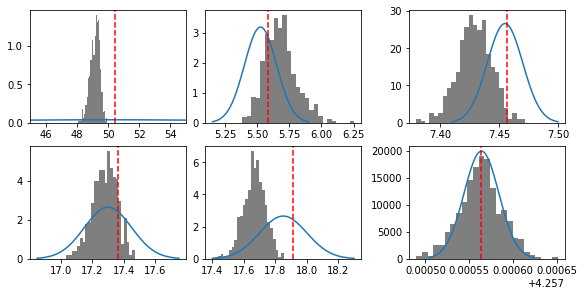

In [300]:
fig, axs = plt.subplots(2,3, figsize=(8,4),constrained_layout=True)
coef = 1/180/3600*np.pi*1e3
# coef=1
freqs_0 = np.hstack([p0, g_k])/coef
for i, ax in enumerate(axs.flatten()):

    # variance = 1
    # sigma = math.sqrt(variance)
    muy, sigma = prior_params_freq[i]/coef
    x = np.linspace(muy - 3*sigma, muy + 3*sigma, 100)
    ax.plot(x, sp.stats.norm.pdf(x, muy, sigma))
    ax.hist(flat_samples[:,len(params_noise_ini)+i]/coef, density=True, color="k", alpha=0.5, bins=25)
    ax.axvline(freqs_0[i], ls="--", color="red")
    # plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black", label="best")
    
    # ax.hist(2*np.pi/(flat_samples[:,1+i]+flat_samples[:,1])*1e3, density=True, color="k", alpha=0.5, bins=25)
    # ax.axvline(2*np.pi/fs[i-1]*1e3)
axs[0,0].set_xlim(45,55)

In [351]:
%matplotlib inline
# flat_samples = sampler.sampler[0].get_chain(discard=200, thin=50, flat=True)
print(flat_samples.shape)
inds = np.random.randint(len(flat_samples), size=1000)
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i,len(params_noise_ini)+6:]], depth) for i in inds])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.025, 0.975],axis=0)
# invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.005, 0.995],axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="median")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black", label="95% CI")

# plt.plot(depth, best_invSR, "--",color="black", label="best", zorder=10)
for i in range(100):
    plt.scatter(depth_genes, flat_samples[i,len(params_noise_ini)+6:], s=0.1, color="black")
plt.plot(depth, invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
# plt.savefig("figures/invSR_sinek10.png")

NameError: name 'flat_samples' is not defined

(600, 28)


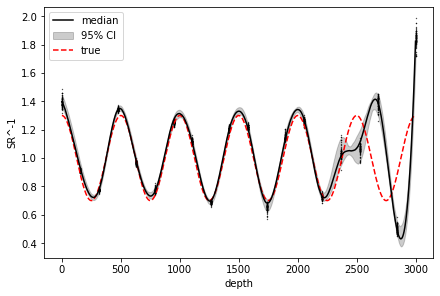

In [306]:
%matplotlib inline
# flat_samples = sampler.sampler[0].get_chain(discard=200, thin=50, flat=True)
print(flat_samples.shape)
inds = np.random.randint(len(flat_samples), size=1000)
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i,len(params_noise_ini)+6:]], depth) for i in inds])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.025, 0.975],axis=0)
# invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.005, 0.995],axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="median")
plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black", label="95% CI")

# plt.plot(depth, best_invSR, "--",color="black", label="best", zorder=10)
for i in range(100):
    plt.scatter(depth_genes, flat_samples[i,len(params_noise_ini)+6:], s=0.1, color="black")
plt.plot(depth, invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
# plt.savefig("figures/invSR_sinek10.png")

(600, 28)


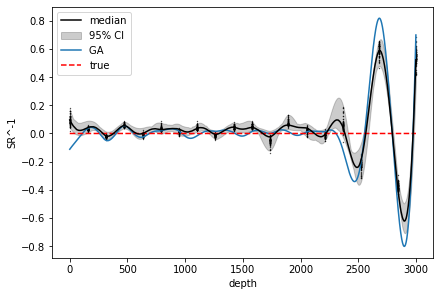

In [303]:
%matplotlib inline
# flat_samples = sampler.sampler[0].get_chain(discard=200, thin=50, flat=True)
print(flat_samples.shape)
inds = np.random.randint(len(flat_samples), size=1000)
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i,len(params_noise_ini)+6:]], depth) for i in inds])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.025, 0.975],axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.005, 0.995],axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR-invSR, zorder=10,color="black", label="median")
# plt.plot(depth, mean_invSR-invSR, zorder=10,color="black", label="median")invSR_best
plt.fill_between(depth, invSR_lo-invSR, invSR_up-invSR, alpha=0.2, color="black", label="95% CI")
plt.plot(depth, interpolator([depth_genes, invSR_best], depth)-invSR,label="GA ")
# plt.plot(depth, best_invSR, "--",color="black", label="best", zorder=10)
for i in range(100):
    plt.scatter(depth_genes, flat_samples[i,len(params_noise_ini)+6:]-func_inv_SR(depth_genes), s=0.1, color="black")
# plt.plot(depth_genes, invSR_best-func_inv_SR(depth_genes),'.')
plt.plot(depth, invSR-invSR, "--", color="red", label="true")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()
# plt.savefig("figures/invSR_sinek10.png")

# GA with p0 as variable

In [13]:
class invSR_p0_inference(ElementwiseProblem):
    """ same as invSRinference, include p0 as genes, input fsp is fs defined without p0 (first fives values are g1,..,5)"""
    def __init__(self, depth_genes, invSR_lims, p0_lims, interpolator, data, fsp, n_pieces=1, metric=metric_piecewise):

        self.invSR_lims = invSR_lims
        self.p0_lims = p0_lims
        self.depth_genes = depth_genes 
        self.interpolator = interpolator
        self.data = data
        self.fsp = fsp

        N_genes_invSR = len(depth_genes)
        xl = np.zeros(N_genes_invSR+1) + invSR_lims[0]
        xu = np.zeros(N_genes_invSR+1) + invSR_lims[1]
        xl[0] = p0_lims[0]; xu[0] = p0_lims[1]
        self.func_metric = partial(metric, data=data, interpolator=interpolator, n_pieces=n_pieces, invSR_lims=invSR_lims)
        super().__init__(n_var=N_genes_invSR+1, n_obj=n_pieces, xl=xl, xu=xu)

    def _evaluate(self, genes, out, *args, **kwargs):
        genes_p0 = genes[0]
        genes_invSR = genes[1:]
        fs = self.fsp.copy()
        fs[:5] += genes_p0
        # print(len(self.depth_genes), len(genes_invSR))
        out["F"] = -self.func_metric([self.depth_genes, genes_invSR], fs=fs)

In [17]:
np.array([50, 100])/180/3600*np.pi*coef_time, p0

(array([0.24240684, 0.48481368]), 0.24467440140777985)

In [39]:
# N_population = 128 # number of individual in population 
# N_generations_max = 100
N_genes = 6 # number of intial gene in an individial of the population 
depth_lims = depth[0], depth[-1]
depth_genes = np.linspace(*depth_lims, N_genes)
true_genes = func_inv_SR(depth_genes)
invSR_lims = [0, 2]
p0_lims = np.array([40, 60])/180/3600*np.pi*coef_time
fsp = np.hstack([g_k, fe_k])
# fs =  np.array([f1, f2])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
n_pieces = 2
metric_optimal = metric_piecewise([depth_genes, func_inv_SR(depth_genes)], [depth, y], np.hstack([g_k+p0, fe_k]), interpolator, n_pieces)
print(metric_optimal, metric_optimal.mean())
# invSR_all = np.zeros((N_generations_max, N_population, N_genes))
# invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
# invSR_all[0] = invSR_ini
# metric_all = np.zeros((N_generations_max, N_population))
# metric_ini = np.array([metric([depth_genes, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
# metric_all[0] = metric_ini
interpolator = interpolate_CubicSpline
data = [depth, y]
problem = invSR_p0_inference(depth_genes, invSR_lims, p0_lims, interpolator, data, fsp, n_pieces=n_pieces, metric=metric_piecewise)
out = {}
genes = np.hstack([p0, func_inv_SR(depth_genes)])
print(problem.fsp)
problem._evaluate(genes, out)
print(problem.fsp)

out


[0.52901898 0.46852584] 0.49877240858670896
[0.02704959 0.03615093 0.08419563 0.08683107 0.02064125 0.01550968
 0.06618982 0.05068014 0.06355438 0.0480447  0.00263544 0.00640834]
[0.02704959 0.03615093 0.08419563 0.08683107 0.02064125 0.01550968
 0.06618982 0.05068014 0.06355438 0.0480447  0.00263544 0.00640834]


{'F': array([-0.52901898, -0.46852584])}

In [135]:
problem.xu, problem.xl

(array([0.48481368, 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        ]),
 array([0.19392547, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]))

## Vanilla

In [127]:
algorithm = NSGA2(
    pop_size=200,
    # n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 200)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

# X = res.X
# F = res.F

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |      7 |             - |             -
     2 |      400 |      7 |  0.0468782587 |         ideal
     3 |      600 |      8 |  0.2039753147 |         ideal
     4 |      800 |     11 |  0.1028121554 |         ideal
     5 |     1000 |     10 |  0.0265004444 |             f
     6 |     1200 |     12 |  0.0500944748 |         ideal
     7 |     1400 |     11 |  0.0081339950 |             f
     8 |     1600 |      9 |  0.2216852877 |         ideal
     9 |     1800 |      2 |  0.0947501416 |         ideal
    10 |     2000 |      2 |  0.000000E+00 |             f
    11 |     2200 |      3 |  0.1136238057 |             f
    12 |     2400 |      4 |  0.1297828076 |         ideal
    13 |     2600 |      7 |  0.1434973353 |         nadir
    14 |     2800 |      8 |  0.0159047923 |         ideal
    15 |     3000 |      7 |  0.0696369931 |         ideal
    16 |     3200 |      7 |  0.1663456031 |         ide

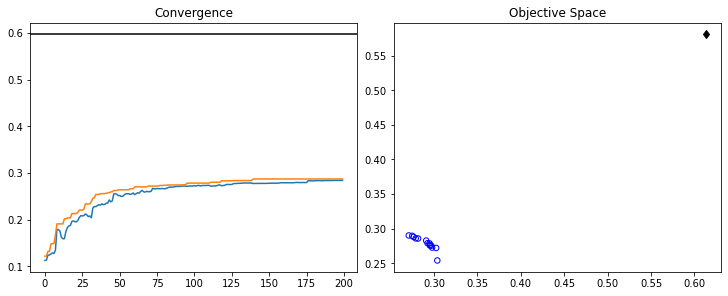

In [134]:
# opt = -np.array([e.opt[0].F for e in res.history])
opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
opt_max = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

plt.figure(figsize=(10,4), constrained_layout=True)
plt.subplot(1,2,1)
plt.title("Convergence")
# plt.plot(opt.mean(axis=1), "--")
plt.plot(opt_mean)
plt.plot(opt_max)
plt.axhline(metric_optimal.mean(), color="k")

# plt.figure(figsize=(7, 5))
plt.subplot(1,2,2)
plt.scatter(-res.F[:, 0], -res.F[:, 1], s=30, facecolors='none', edgecolors='blue')
f1min, f1max = -res.F[:,0].min(), -res.F[:,0].max()
f1grid = np.linspace(0, 1, 100)

# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()

# plt.yscale("log")
plt.show()

In [130]:
res.X[0,0], p0

(0.39322639335536236, 0.24467440140777985)

In [145]:
p0, res.X[:,0]

(0.24467440140777985,
 array([0.39322639, 0.39347003, 0.39303683, 0.37920445, 0.37998299,
        0.39412862, 0.39454615, 0.39459847, 0.39459847, 0.39303683,
        0.39459847, 0.37630677, 0.37920445, 0.37920445]))

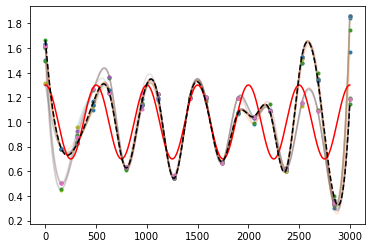

In [141]:
# invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
res.F.shape, res.X.shape
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best,1:]

for i in range(res.F.shape[0]):
    plt.plot(depth_genes, res.X[i,1:], '.')
    invSR_interpolate = interpolator([depth_genes, res.X[i,1:]], depth)
    plt.plot(depth, invSR_interpolate, alpha=0.2)
plt.plot(depth, invSR, color="red")
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black")
# invSR_interpolate[invSR_interpolate<0] = 0

time = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
X = generate_X_linReg(np.ones_like(fs), fs, time)

reg_model = LinearRegression().fit(X, y)
y_pred = reg_model.predict(X)



## Search for optimal genes length

In [116]:
# N_population = 128 # number of individual in population 
# N_generations_max = 100
N_genes = 20 # number of intial gene in an individial of the population 
depth_lims = depth[0], depth[-1]
depth_genes = np.linspace(*depth_lims, N_genes)
true_genes = func_inv_SR(depth_genes)
invSR_lims = [0, 2]
p0_lims = np.array([40, 100])/180/3600*np.pi*coef_time
fsp = np.hstack([g_k, fe_k])
# fsp = np.hstack([g_k])
# fs =  np.array([f1, f2])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
n_pieces = 2
metric_optimal = metric_piecewise([depth_genes, func_inv_SR(depth_genes)], [depth, y], np.hstack([g_k+p0, fe_k]), interpolator, n_pieces)
print(metric_optimal, metric_optimal.mean())
# invSR_all = np.zeros((N_generations_max, N_population, N_genes))
# invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
# invSR_all[0] = invSR_ini
# metric_all = np.zeros((N_generations_max, N_population))
# metric_ini = np.array([metric([depth_genes, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
# metric_all[0] = metric_ini
interpolator = interpolate_CubicSpline
data = [depth, y]
problem = invSR_p0_inference(depth_genes, invSR_lims, p0_lims, interpolator, data, fsp, n_pieces=n_pieces, metric=metric_piecewise)
out = {}
genes = np.hstack([p0, func_inv_SR(depth_genes)])
problem._evaluate(genes, out)
out

[0.60585559 0.48669608] 0.5462758389018918


{'F': array([-0.60585559, -0.48669608])}

In [117]:
algorithm = NSGA2(
    pop_size=400,
    # n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
N_generations = 400
termination = get_termination("n_gen", N_generations)

# N_genes_enemble = np.arange(10, 60, 4)
# N_genes_enemble = np.array([20]*400)
# depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1], N_genes) for N_genes in N_genes_enemble] 
# N_ensemble = len(depth_genes_ensemble)
# fsp = np.hstack([g_k, fe_k])

N_trial = 5
N_genes_distinct = np.arange(2, 20, 1)
N_genes_enemble = np.array([ np.array([i]*N_trial)  for i in  N_genes_distinct]).flatten()
depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1],N_genes) for N_genes in N_genes_enemble] 

N_ensemble = len(depth_genes_ensemble)


problems = [invSR_p0_inference(depth_genes, invSR_lims, p0_lims, interpolator, data, fsp, n_pieces=n_pieces, metric=metric_piecewise) for depth_genes in depth_genes_ensemble  ] 


res_ensemble = Parallel(n_jobs=len(problems), verbose=100)(delayed(minimize)(problem, algorithm, termination, 
                                                                          save_history=False, callback=Callback_getF())
                                                        for problem in problems)

# opt_max_ensemble = np.zeros([N_ensemble,N_generations])
# for i in range(N_ensemble):
#     res = res_ensemble[i]
#     opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])
# ind_sort = np.argsort(opt_max_ensemble[:,-1])
# res_ensemble = [res_ensemble[i] for i in  ind_sort]
# opt_max_ensemble = opt_max_ensemble[ind_sort]

[Parallel(n_jobs=90)]: Using backend LokyBackend with 90 concurrent workers.
[Parallel(n_jobs=90)]: Done   1 tasks      | elapsed:  4.7min
[Parallel(n_jobs=90)]: Done   2 out of  90 | elapsed:  4.7min remaining: 206.8min
[Parallel(n_jobs=90)]: Done   3 out of  90 | elapsed:  4.7min remaining: 136.8min
[Parallel(n_jobs=90)]: Done   4 out of  90 | elapsed:  4.7min remaining: 101.5min
[Parallel(n_jobs=90)]: Done   5 out of  90 | elapsed:  4.7min remaining: 80.3min
[Parallel(n_jobs=90)]: Done   6 out of  90 | elapsed:  4.7min remaining: 66.1min
[Parallel(n_jobs=90)]: Done   7 out of  90 | elapsed:  4.7min remaining: 56.2min
[Parallel(n_jobs=90)]: Done   8 out of  90 | elapsed:  4.7min remaining: 48.7min
[Parallel(n_jobs=90)]: Done   9 out of  90 | elapsed:  4.8min remaining: 42.8min
[Parallel(n_jobs=90)]: Done  10 out of  90 | elapsed:  4.8min remaining: 38.1min
[Parallel(n_jobs=90)]: Done  11 out of  90 | elapsed:  4.8min remaining: 34.2min
[Parallel(n_jobs=90)]: Done  12 out of  90 | ela

/tmp/ipykernel_3708676/2163694092.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


Text(0, 0.5, 'r2')

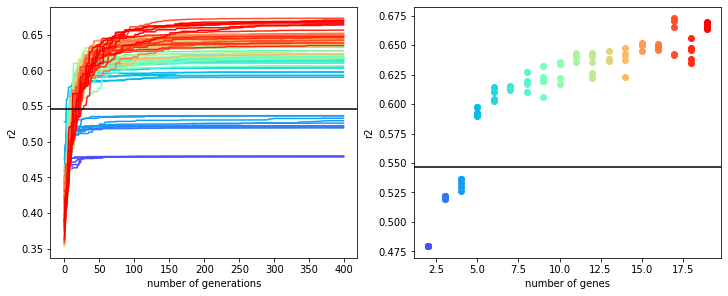

In [118]:
# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(10,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
plt.subplot(1,2,1)

cmap = plt.get_cmap("rainbow")

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])

    # opt_max_ensemble[i] = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

    # plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
    plt.plot(opt_max_ensemble[i], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))

fs = np.hstack([g_k+p0, fe_k])
metric_optimal = metric_piecewise([depth, func_inv_SR(depth)], [depth, y], fs, interpolator, 2)
plt.ylabel("r2")
plt.xlabel("number of generations")
# plt.ylim([0.1, 0.8])
plt.axhline(metric_optimal.mean(), color="k")

# plt.yscale("log")
plt.subplot(1,2,2)
# ax2 = fig.add_subplot(gs1[0, 1])

# plt.plot(N_genes_enemble, opt_max_ensemble[:,-1], '.-')
# [ for i in range(N_ensemble)]
for i in range(N_ensemble):
    plt.scatter(N_genes_enemble[i], opt_max_ensemble[i,-1], color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
    # metric_optimal = metric_piecewise([depth_genes_ensemble[i], func_inv_SR(depth_genes_ensemble[i])], [depth, y], fs, interpolator, n_pieces)
    # plt.axhline(metric_optimal.mean() , color=cmap(i/N_ensemble),zorder=-10)
plt.axhline(metric_optimal.mean(), color="k")

plt.xlabel("number of genes")
plt.ylabel("r2")
# plt.ylim([0.1, 0.8])
# plt.savefig("r2_Ngenesb.png", dpi=200)

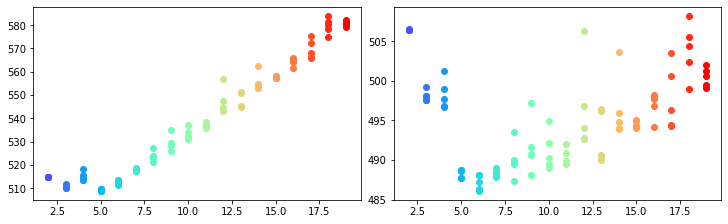

In [139]:
def maxlogL_to_BIC(maxlogL, n_params, n_data):
    return n_params*np.log(n_data) - 2*maxlogL
def maxlogL_to_AIC(maxlogL, n_params):
    return n_params*2 - 2*maxlogL


fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
rho = rho_true
sigma = sigma_true
for i, res in enumerate(res_ensemble):
    res = res_ensemble[i]
    # if i<=40:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    # maxlogL  = log_likelihood_rednoise([depth_genes, func_inv_SR(depth_genes)], data, fs, [rho_true, sigma_true], interpolator=interpolate_CubicSpline)
    maxlogL  = log_likelihood_rednoise([depth_genes, res.X[arg_best,1:]], data, np.hstack([g_k+res.X[arg_best,0], fe_k]), [sigma, rho], interpolator=interpolate_CubicSpline)

    # plt.scatter(N_genes_enemble[i], maxlogL, color=cmap(i/N_ensemble))
    axs[0].scatter(N_genes_enemble[i], maxlogL_to_BIC(maxlogL, N_genes_enemble[i], len(y)), color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))
    axs[1].scatter(N_genes_enemble[i], maxlogL_to_AIC(maxlogL, N_genes_enemble[i]), color=cmap(N_genes_enemble[i]/N_genes_enemble[-1]))

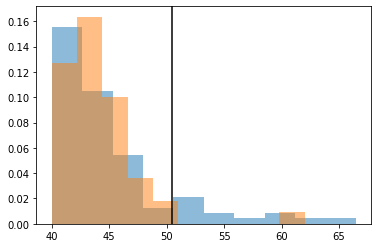

In [119]:
%matplotlib inline
p0_best_ensemble = np.hstack([resi.X[np.argmin(resi.F.mean(axis=1)),0] for resi in res_ensemble[:] ])
# p0_ensemble.shape
plt.hist(p0_best_ensemble/arcsec_to_pi/1e3,density=True,alpha=0.5)
plt.hist(p0_best_ensemble[-50:]/arcsec_to_pi/1e3,density=True, alpha=0.5)

# plt.hist(np.hstack([resi.X[:,0] for resi in res_ensemble[:] ])/arcsec_to_pi/1e6, bins=50)
# plt.hist(np.hstack([resi.X[:,0] for resi in res_ensemble[-50:] ])/arcsec_to_pi/1e6)
plt.axvline(p0/arcsec_to_pi/1e3, color="black")
# plt.xlim(*p0_lims/arcsec_to_pi/1e3)
# plt.xlim([45,55])

[0.58425481 0.47434718]
0.571940235874755


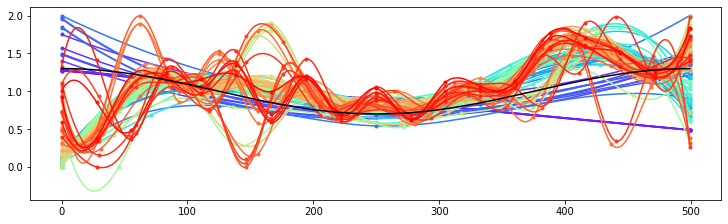

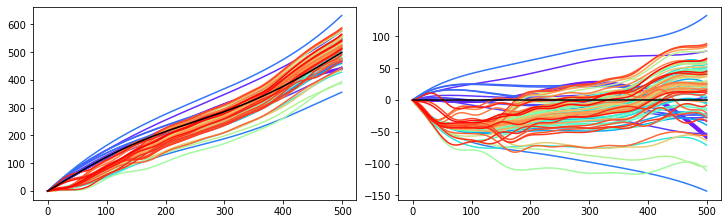

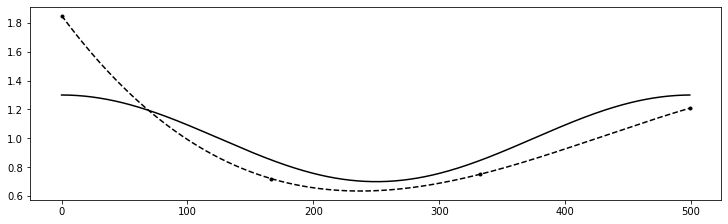

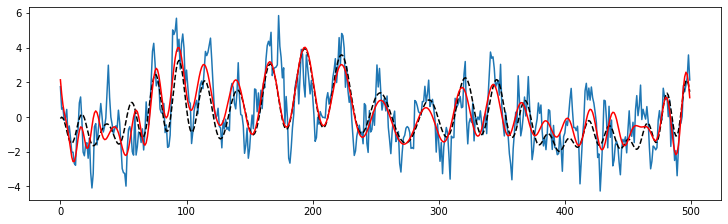

In [133]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_inv_SR(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")
# invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+p0, fe_k]), interpolator=interpolator)

for i, res in enumerate(res_ensemble):
# for i, res in enumerate(reversed(res_ensemble)):

    # if i<2:
    #     continue
    # res = res_ensemble[i]
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    ax.plot(depth, interpolator([depth_genes, res.X[arg_best,1:]], depth), color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best,1:], '.', color=cmap(i/N_ensemble))

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
for i, res in enumerate(res_ensemble):
# for i, res in enumerate(reversed(res_ensemble)):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)
    time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])
    axs[0].plot(depth, time, color=cmap(i/N_ensemble))
    axs[1].plot(depth, time-times_true, color=cmap(i/N_ensemble))
axs[0].plot(depth, times_true, color="black")
axs[1].plot(depth, depth*0, color="k")

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_inv_SR(depth),color="black")
# i = -15
i = 10

res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]
arg_best = np.argmin(res.F.mean(axis=1))
print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best,1:]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best,1:], '.', color="black")
# ax.set_ylim(invSR_lims)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)

time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])
ax.plot(depth, y )
ax.plot(depth, y_model, "--",color="black")
ax.plot(depth, y_pred, color="red")
print(r2_score(y, y_pred))
# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

## many

In [142]:
# N_population = 128 # number of individual in population 
# N_generations_max = 100
N_genes = 20 # number of intial gene in an individial of the population 
depth_lims = depth[0], depth[-1]
depth_genes = np.linspace(*depth_lims, N_genes)
true_genes = func_inv_SR(depth_genes)
invSR_lims = [0, 2]
p0_lims = np.array([40, 100])/180/3600*np.pi*coef_time
fsp = np.hstack([g_k, fe_k])
# fsp = np.hstack([g_k])
# fs =  np.array([f1, f2])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
n_pieces = 2
metric_optimal = metric_piecewise([depth_genes, func_inv_SR(depth_genes)], [depth, y], np.hstack([g_k+p0, fe_k]), interpolator, n_pieces)
print(metric_optimal, metric_optimal.mean())
# invSR_all = np.zeros((N_generations_max, N_population, N_genes))
# invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
# invSR_all[0] = invSR_ini
# metric_all = np.zeros((N_generations_max, N_population))
# metric_ini = np.array([metric([depth_genes, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
# metric_all[0] = metric_ini
interpolator = interpolate_CubicSpline
data = [depth, y]
problem = invSR_p0_inference(depth_genes, invSR_lims, p0_lims, interpolator, data, fsp, n_pieces=n_pieces, metric=metric_piecewise)
out = {}
genes = np.hstack([p0, func_inv_SR(depth_genes)])
problem._evaluate(genes, out)
out

[0.46098777 0.49133673] 0.4761622514297648


{'F': array([-0.46098777, -0.49133673])}

In [146]:
algorithm = NSGA2(
    # pop_size=400,
    pop_size=200,
    # n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
N_generations = 400
termination = get_termination("n_gen", N_generations)

# N_genes_enemble = np.arange(10, 60, 4)
N_genes_enemble = np.array([20]*64*4)
depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1], N_genes) for N_genes in N_genes_enemble] 
N_ensemble = len(depth_genes_ensemble)
fsp = np.hstack([g_k, fe_k])

# N_trial = 4
# N_genes_distinct = np.arange(2, 60, 2)
# N_genes_enemble = np.array([ np.array([i]*N_trial)  for i in  N_genes_distinct]).flatten()
# depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1],N_genes) for N_genes in N_genes_enemble] 

# N_ensemble = len(depth_genes_ensemble)


problems = [invSR_p0_inference(depth_genes, invSR_lims, p0_lims, interpolator, data, fsp, n_pieces=n_pieces, metric=metric_piecewise) for depth_genes in depth_genes_ensemble] 


res_ensemble = Parallel(n_jobs=64, verbose=100)(delayed(minimize)(problem, algorithm, termination, 
                                                                          save_history=False, callback=Callback_getF())
                                                        for problem in problems)

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = -np.array(res.algorithm.callback.data["best"])
ind_sort = np.argsort(opt_max_ensemble[:,-1])
res_ensemble = [res_ensemble[i] for i in  ind_sort]
opt_max_ensemble = opt_max_ensemble[ind_sort]

[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:  9.4min
[Parallel(n_jobs=64)]: Done   2 tasks      | elapsed:  9.6min
[Parallel(n_jobs=64)]: Done   3 tasks      | elapsed:  9.9min
[Parallel(n_jobs=64)]: Done   4 tasks      | elapsed:  9.9min
[Parallel(n_jobs=64)]: Done   5 tasks      | elapsed: 10.0min
[Parallel(n_jobs=64)]: Done   6 tasks      | elapsed: 10.5min
[Parallel(n_jobs=64)]: Done   7 tasks      | elapsed: 10.8min
[Parallel(n_jobs=64)]: Done   8 tasks      | elapsed: 11.0min
[Parallel(n_jobs=64)]: Done   9 tasks      | elapsed: 11.3min
[Parallel(n_jobs=64)]: Done  10 tasks      | elapsed: 12.4min
[Parallel(n_jobs=64)]: Done  11 tasks      | elapsed: 12.4min
[Parallel(n_jobs=64)]: Done  12 tasks      | elapsed: 13.2min
[Parallel(n_jobs=64)]: Done  13 tasks      | elapsed: 13.3min
[Parallel(n_jobs=64)]: Done  14 tasks      | elapsed: 13.4min
[Parallel(n_jobs=64)]: Done  15 tasks      | elapsed: 13.6min
[Parallel(n_jobs=64)]: Done  16 tasks      | elapsed: 13.8min
[Paralle

/tmp/ipykernel_2152822/644410043.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


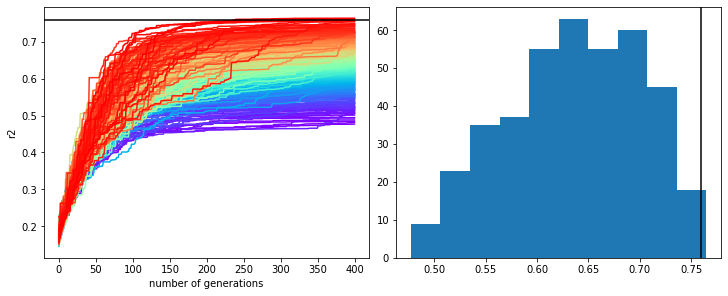

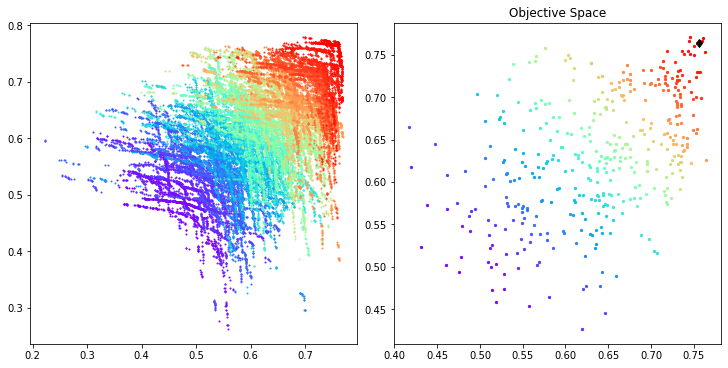

In [14]:

# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(10,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
# plt.subplot(1,1,1)
metric_optimal = metric_piecewise([depth, func_inv_SR(depth)], [depth, y], np.hstack([g_k+p0,fe_k]), interpolator, n_pieces)

cmap = plt.get_cmap("rainbow")
plt.subplot(1,2,1)
for i in range(N_ensemble):

    plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))

plt.axhline(metric_optimal.mean(), color="k")
plt.ylabel("r2")
plt.xlabel("number of generations")
plt.subplot(1,2,2)
plt.hist(opt_max_ensemble[:,-1])
plt.axvline(metric_optimal.mean(), color="k")

# plt.ylim([0.1, 0.8])
# plt.axhline(metric_optimal.mean(), color="k")


fig, axs = plt.subplots(1, 2, figsize=(10, 5),constrained_layout=True)
# plt.subplot(1,2,1)

for i in range(N_ensemble):
    res = res_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    axs[0].scatter(-res.F[:, 0], -res.F[:, 1], s=1, color=cmap(i/N_ensemble))
    axs[1].scatter(-res.F[arg_best, 0], -res.F[arg_best, 1], s=5, color=cmap(i/N_ensemble))
# plt.subplot(1,2,2)

f1min, f1max = -res.F[:,0].min(), -res.F[:,1].max()
f1grid = np.linspace(0, 1, 100)
# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()


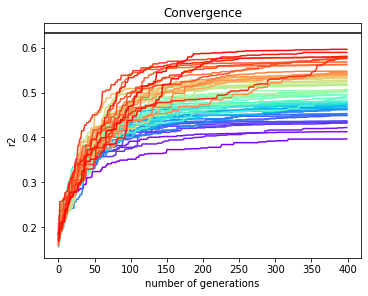

In [73]:

# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(5,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
plt.subplot(1,1,1)

cmap = plt.get_cmap("rainbow")

for i in range(N_ensemble):

    plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))


metric_optimal = metric_piecewise([depth, func_inv_SR(depth)], [depth, y], np.hstack([g_k+p0,fe_k]), interpolator, n_pieces)
plt.ylabel("r2")
plt.xlabel("number of generations")
# plt.ylim([0.1, 0.8])
plt.axhline(metric_optimal.mean(), color="k")


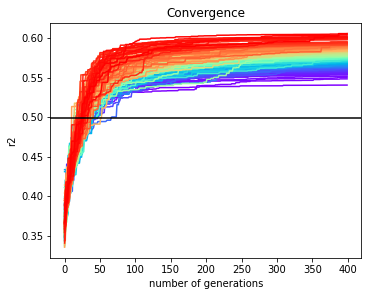

In [128]:

# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
%matplotlib inline
fig = plt.figure(constrained_layout=True, figsize=(5,4))
plt.title("Convergence")
# gs1 = fig.add_gridspec(nrows=1, ncols=2, hspace=0.05, wspace=0.05,
                    #    height_ratios=(6, 4), width_ratios=(35, 65))
# ax1 = fig.add_subplot(gs1[0, 0])
# ax2 = fig.add_subplot(gs1[0, 1])
plt.subplot(1,1,1)

cmap = plt.get_cmap("rainbow")

for i in range(N_ensemble):


    plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))


metric_optimal = metric_piecewise([depth, func_inv_SR(depth)], [depth, y], np.hstack([g_k+p0,fe_k]), interpolator, n_pieces)
plt.ylabel("r2")
plt.xlabel("number of generations")
# plt.ylim([0.1, 0.8])
plt.axhline(metric_optimal.mean(), color="k")


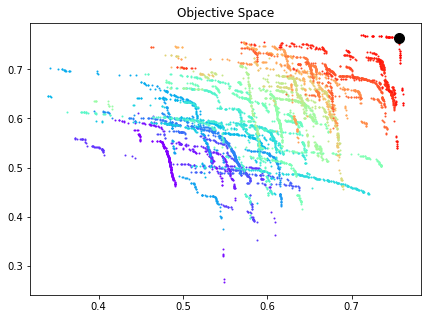

In [128]:
%matplotlib inline
plt.figure(figsize=(7, 5))
metric_optimal = metric_piecewise([depth, func_inv_SR(depth)], [depth, y], np.hstack([g_k+p0,fe_k]), interpolator, n_pieces)

for i in range(N_ensemble):
    res = res_ensemble[i]
    plt.scatter(-res.F[:, 0], -res.F[:, 1], s=1, color=cmap(i/N_ensemble))
f1min, f1max = -res.F[:,0].min(), -res.F[:,1].max()
f1grid = np.linspace(0, 1, 100)
plt.scatter(*metric_optimal, s=100, marker='o', color="black")
# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()


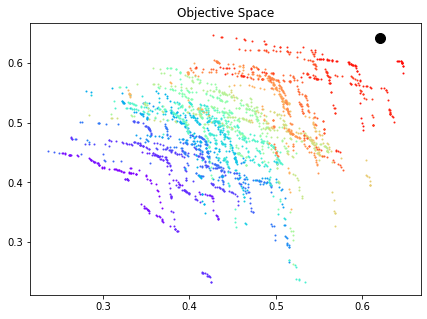

In [35]:
%matplotlib inline
plt.figure(figsize=(7, 5))
metric_optimal = metric_piecewise([depth, func_inv_SR(depth)], [depth, y], np.hstack([g_k+p0,fe_k]), interpolator, n_pieces)

for i in range(N_ensemble):
    res = res_ensemble[i]
    plt.scatter(-res.F[:, 0], -res.F[:, 1], s=1, color=cmap(i/N_ensemble))
f1min, f1max = -res.F[:,0].min(), -res.F[:,1].max()
f1grid = np.linspace(0, 1, 100)
plt.scatter(*metric_optimal, s=100, marker='o', color="black")
# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()


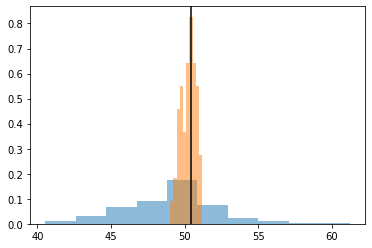

In [66]:
%matplotlib inline
p0_best_ensemble = np.hstack([resi.X[np.argmin(resi.F.mean(axis=1)),0] for resi in res_ensemble[:] ])
# p0_ensemble.shape
plt.hist(p0_best_ensemble/arcsec_to_pi/1e3,density=True,alpha=0.5)
plt.hist(p0_best_ensemble[-50:]/arcsec_to_pi/1e3,density=True, alpha=0.5)

# plt.hist(np.hstack([resi.X[:,0] for resi in res_ensemble[:] ])/arcsec_to_pi/1e6, bins=50)
# plt.hist(np.hstack([resi.X[:,0] for resi in res_ensemble[-50:] ])/arcsec_to_pi/1e6)
plt.axvline(p0/arcsec_to_pi/1e3, color="black")
# plt.xlim(*p0_lims/arcsec_to_pi/1e3)
# plt.xlim([45,55])

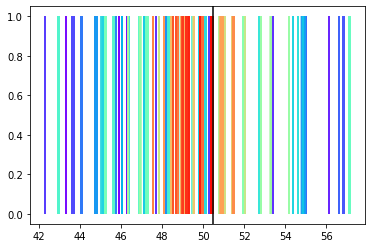

In [130]:
for i in range(N_ensemble):
    res = res_ensemble[i]
    plt.vlines(res.X[:,0]/arcsec_to_pi/1e3, 0, 1, color=cmap(i/N_ensemble), alpha=0.5 )
    # plt.scatter(-res.F[:, 0], -res.F[:, 1], s=1, color=cmap(i/N_ensemble))
plt.axvline(p0/arcsec_to_pi/1e3, color="black")

In [26]:
res = res_ensemble[-1]
arg_best = np.argmin(res.F.mean(axis=1))
res.X[arg_best,0], p0

(0.2380030794696083, 0.24467440140777985)

[0.64145704 0.60232718]
0.6253272727245904


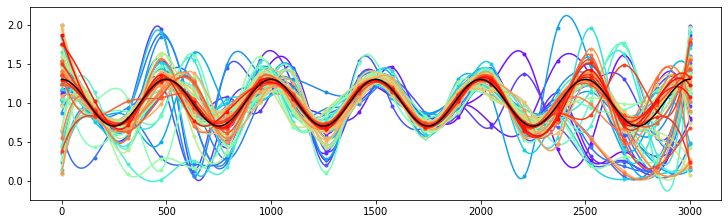

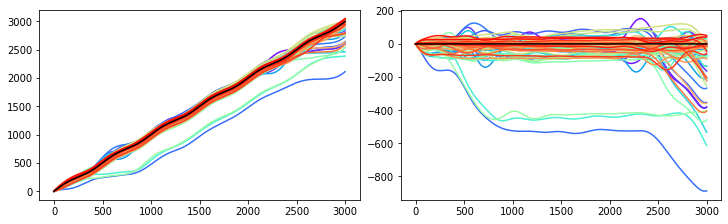

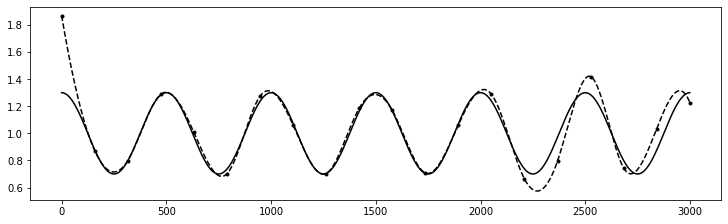

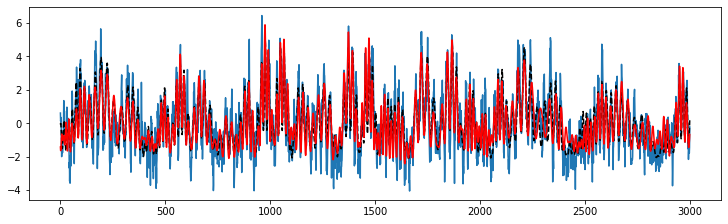

In [143]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_inv_SR(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")
# invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+p0, fe_k]), interpolator=interpolator)

for i, res in enumerate(res_ensemble):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    ax.plot(depth, interpolator([depth_genes, res.X[arg_best,1:]], depth), color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best,1:], '.', color=cmap(i/N_ensemble))

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
for i, res in enumerate(res_ensemble):
# for i, res in enumerate(reversed(res_ensemble)):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)
    time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])
    axs[0].plot(depth, time, color=cmap(i/N_ensemble))
    axs[1].plot(depth, time-times_true, color=cmap(i/N_ensemble))
axs[0].plot(depth, times_true, color="black")
axs[1].plot(depth, depth*0, color="k")

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_inv_SR(depth),color="black")
# i = -15
i = -1

res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]
arg_best = np.argmin(res.F.mean(axis=1))
print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best,1:]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best,1:], '.', color="black")
# ax.set_ylim(invSR_lims)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)

time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])
ax.plot(depth, y )
ax.plot(depth, y_model, "--",color="black")
ax.plot(depth, y_pred, color="red")
print(r2_score(y, y_pred))
# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

[0.76030431 0.76925803]
0.7654733696342902


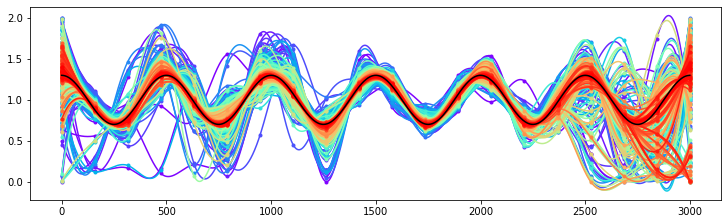

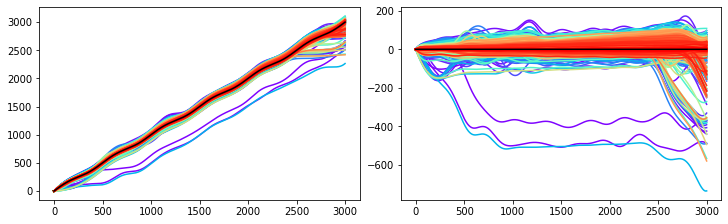

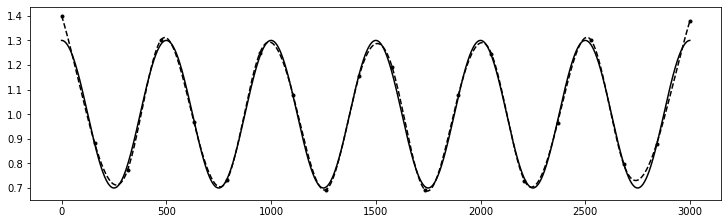

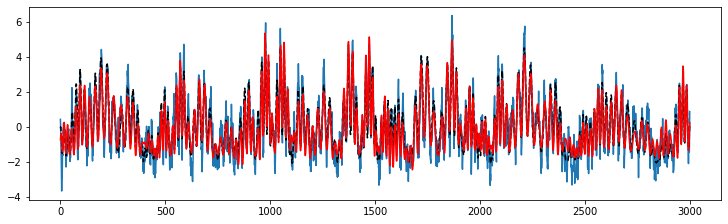

In [17]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_inv_SR(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")
invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+p0, fe_k]), interpolator=interpolator)

for i, res in enumerate(res_ensemble):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    ax.plot(depth, interpolator([depth_genes, res.X[arg_best,1:]], depth), color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best,1:], '.', color=cmap(i/N_ensemble))

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
for i, res in enumerate(res_ensemble):
# for i, res in enumerate(reversed(res_ensemble)):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)
    time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])
    axs[0].plot(depth, time, color=cmap(i/N_ensemble))
    axs[1].plot(depth, time-times_true, color=cmap(i/N_ensemble))
axs[0].plot(depth, times_true, color="black")
axs[1].plot(depth, depth*0, color="k")

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_inv_SR(depth),color="black")
# i = -15
i = -1

res = res_ensemble[i]
depth_genes = depth_genes_ensemble[i]
arg_best = np.argmin(res.F.mean(axis=1))
print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best,1:]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best,1:], '.', color="black")
# ax.set_ylim(invSR_lims)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)

time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])
ax.plot(depth, y )
ax.plot(depth, y_model, "--",color="black")
ax.plot(depth, y_pred, color="red")
print(r2_score(y, y_pred))
# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

0.050877256780298814 0.050467
[0.49358322 0.47786304]
0.4876971883691361


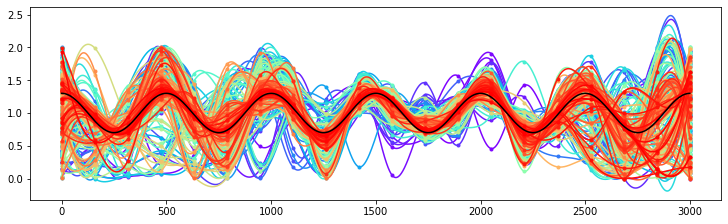

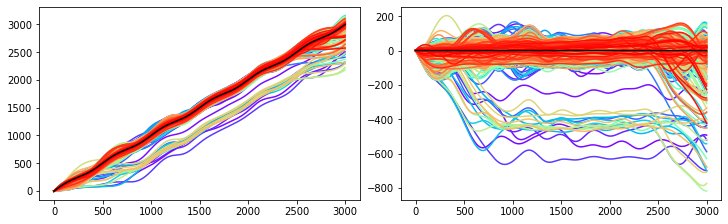

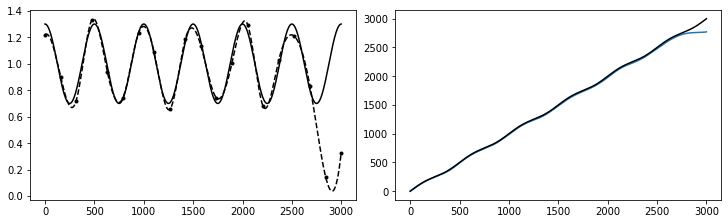

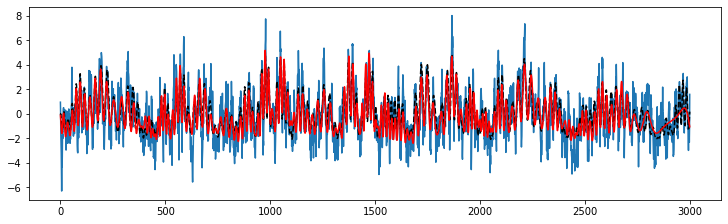

In [159]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, func_inv_SR(depth),color="black",zorder=100)
cmap = plt.get_cmap("rainbow")
invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+p0, fe_k]), interpolator=interpolator)

for i, res in enumerate(res_ensemble):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    ax.plot(depth, interpolator([depth_genes, res.X[arg_best,1:]], depth), color=cmap(i/N_ensemble))
    ax.plot(depth_genes, res.X[arg_best,1:], '.', color=cmap(i/N_ensemble))

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
cmap = plt.get_cmap("rainbow")
for i, res in enumerate(res_ensemble):
# for i, res in enumerate(reversed(res_ensemble)):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)
    time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])
    axs[0].plot(depth, time, color=cmap(i/N_ensemble))
    axs[1].plot(depth, time-times_true, color=cmap(i/N_ensemble))
axs[0].plot(depth, times_true, color="black")
axs[1].plot(depth, depth*0, color="k")

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10,3))
# ax.plot(depth, func_invSR_nominal(depth),color="black")
# i = -15
i = -1
res = res_ensemble[i]
arg_best = np.argmin(res.F.mean(axis=1))
depth_genes = depth_genes_ensemble[i]

invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)
time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])

ax = axs[0]
print(res.X[arg_best,0]/arcsec_to_pi/1e6, p0//arcsec_to_pi/1e6)

print(-res.F[arg_best])
ax.plot(depth, interpolator([depth_genes, res.X[arg_best,1:]], depth), "--", color="black")
ax.plot(depth_genes, res.X[arg_best,1:], '.', color="black")
ax.plot(depth, func_inv_SR(depth),color="black")

ax = axs[1]
ax.plot(depth, time)
ax.plot(depth, times_true,color="black")

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=np.hstack([g_k+res.X[arg_best,0], fe_k]), interpolator=interpolator)

time, y_pred = invSR_to_predx([depth_genes, res.X[arg_best,1:]])
ax.plot(depth, y )
ax.plot(depth, y_model, "--",color="black")
ax.plot(depth, y_pred, color="red")
print(r2_score(y, y_pred))
# ax.plot(time, y )
# ax.plot(time, y_pred, color="black")

In [168]:
res = res_ensemble[-1]
arg_best = np.argmin(res.F.mean(axis=1))
p0_res = res.X[arg_best, 0]
# p0_res = p0 
reg = linear_model.LinearRegression()

fs = np.hstack([g_k + p0_res, fe_k])
print(p0_res/arcsec_to_pi/1e3, p0/arcsec_to_pi/1e3)

# fs = np.hstack([g_k + p0, fe_k])
invSR_interpolate = interpolator([depth_genes, res.X[arg_best,1:]], depth)
timesx = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)

# X = generate_X_linReg(np.ones_like(fs), fs, times_true)
X = generate_X_linReg(np.ones_like(fs), fs, timesx)

reg.fit(X, y)
# reg.fit(X, y_model)

y_pred = reg.predict(X)
print(r2_score(y, y_pred))
print(r2_score(y[:N_data//2], y_pred[:N_data//2]))
print(r2_score(y[N_data//2:], y_pred[N_data//2:]))


50.12357593271878 50.46771799999999
0.6253272727245904
0.6414570445429861
0.6023271802451784


In [64]:
res = res_ensemble[-1]
arg_best = np.argmin(res.F.mean(axis=1))
p0_res = res.X[arg_best, 0]
# p0_res = p0 
reg = linear_model.LinearRegression()
p0_grid = np.linspace(*p0_lims, 1000)
r2s = np.zeros(len(p0_grid))
invSR_interpolate = interpolator([depth_genes, res.X[arg_best,1:]], depth)
timesx = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
print(p0_res/arcsec_to_pi/1e3, p0/arcsec_to_pi/1e3)

for i, p0i in enumerate(p0_grid):
    fs = np.hstack([g_k + p0i, fe_k])
    # fs = np.hstack([g_k + p0, fe_k])

    # X = generate_X_linReg(np.ones_like(fs), fs, times_true)
    X = generate_X_linReg(np.ones_like(fs), fs, timesx)

    reg.fit(X, y)
# reg.fit(X, y_model)

    y_pred = reg.predict(X)
    r2s[i] = r2_score(y, y_pred)
print(r2_score(y, y_pred))
print(r2_score(y[:N_data//2], y_pred[:N_data//2]))
print(r2_score(y[N_data//2:], y_pred[N_data//2:]))


51.047596259055936 50.46771799999999
0.325715043792577
0.30373666285207745
0.3443666048339751


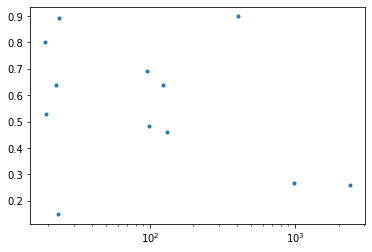

In [171]:
# ABs = reg.coef_
amp = np.sqrt(reg.coef_[:len(fs)]**2 + reg.coef_[len(fs):]**2)
plt.plot(2*np.pi/fs, amp,'.')
plt.xscale("log")

45.899739586279 50.46771799999999
0.3369586115589417
0.31593381481921
0.35464531731325977


(45.0, 55.0)

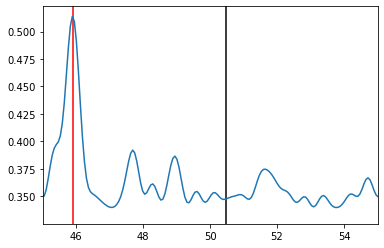

In [139]:
res = res_ensemble[-0]
arg_best = np.argmin(res.F.mean(axis=1))
p0_res = res.X[arg_best, 0]
# p0_res = p0 
reg = linear_model.LinearRegression()
p0_grid = np.linspace(*p0_lims, 1000)
r2s = np.zeros(len(p0_grid))
invSR_interpolate = interpolator([depth_genes, res.X[arg_best,1:]], depth)
timesx = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
print(p0_res/arcsec_to_pi/1e3, p0/arcsec_to_pi/1e3)

for i, p0i in enumerate(p0_grid):
    fs = np.hstack([g_k + p0i, fe_k])
    # fs = np.hstack([g_k + p0, fe_k])

    # X = generate_X_linReg(np.ones_like(fs), fs, times_true)
    X = generate_X_linReg(np.ones_like(fs), fs, timesx)

    reg.fit(X, y)
# reg.fit(X, y_model)

    y_pred = reg.predict(X)
    r2s[i] = r2_score(y, y_pred)
print(r2_score(y, y_pred))
print(r2_score(y[:N_data//2], y_pred[:N_data//2]))
print(r2_score(y[N_data//2:], y_pred[N_data//2:]))

plt.plot(p0_grid/(1/180/3600*np.pi*coef_time), r2s)
plt.axvline(p0/(1/180/3600*np.pi*coef_time), color="black",zorder=-10)
plt.axvline(p0_res/(1/180/3600*np.pi*coef_time), color="red",zorder=-10)
plt.xlim([40,70])
plt.xlim([45,55])

# plt.xlim([0.23, 0.3])

In [19]:
N_indi = 10
# invSR_pop = np.zeros([len(depth), len(res_ensemblex), N_indi])
invSR_pop_best = np.zeros([len(depth), len(res_ensemble)])

for i, res in enumerate(res_ensemble):
    # if i<2:
    #     continue
    depth_genes = depth_genes_ensemble[i]
    arg_best = np.argmin(res.F.sum(axis=1))
    invSR_pop_best[:,i] = interpolator([depth_genes, res.X[arg_best,1:]], depth)
    # for j in range(N_indi):
    #     invSR_pop[:, i, j] = interpolator([depth_genes, res.X[j,1:]], depth)
        # ax.plot(depth, interpolator([depth_genes, res.X[j]], depth), color="black",alpha=0.1)
        # ax.plot(depth_genes, res.X[j], '.', alpha=0.1, color="black")
# invSR_pop = invSR_pop.reshape(len(depth), -1)

In [55]:
invSR_pop_best.shape

(3000, 400)

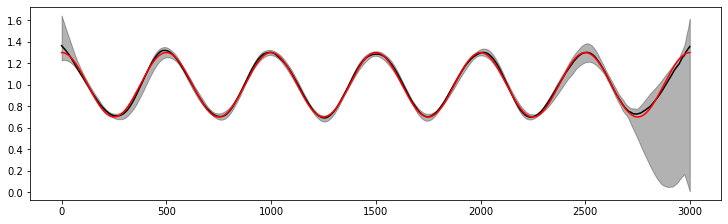

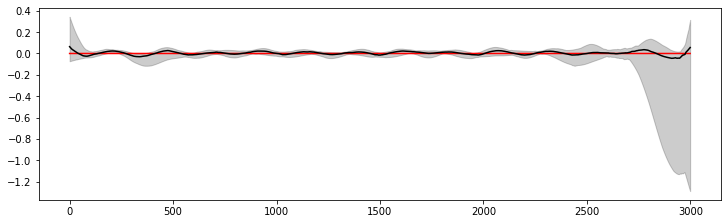

In [69]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))

invSR_popx = invSR_pop_best[:,-50:]
CI = 0.9
# ax.plot(depth, np.median(invSR_pop_best,axis=-1))
# ax.fill_between(depth, *np.quantile(invSR_pop_best, [0.25, 0.75], axis=-1), alpha=0.5)
ax.plot(depth, np.median(invSR_popx,axis=-1),color="k")
ax.fill_between(depth, *np.quantile(invSR_popx, [(1-CI)/2, (1+CI)/2], axis=-1), alpha=0.3, color="k")
ax.plot(depth, func_inv_SR(depth),color="red",zorder=100)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))

mean_invSR = np.median(invSR_popx,axis=-1)
invSR_lo, invSR_up = np.quantile(invSR_popx, [(1-CI)/2, (1+CI)/2],axis=-1)
# invSR_lo, invSR_up = np.quantile(invSR_pop_best, [0.005, 0.995],axis=-1)

# fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, depth*0, color="red")
plt.plot(depth, mean_invSR-func_inv_SR(depth), zorder=10,color="black", label="median")
plt.fill_between(depth, invSR_lo-func_inv_SR(depth), invSR_up-func_inv_SR(depth), alpha=0.2, color="black", label="95% CI")

### Test new plot

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [163]:
n, m = 25, 25
p0_grid = np.linspace(40,100,n)
p0_grid = p0_grid*1/180/3600*np.pi*coef_time
T_grid = np.linspace(1, 4, m)*1e3
p0_mg, T_mg = np.meshgrid(p0_grid, T_grid)
r2_grid = np.zeros((m, n))
depth_genes = depth_genes_ensemble[0]

r2_ensemble = []
T_ensemble = []
p0_ensemble = []
for res in res_ensemble:
    for i_sol in range(res.X.shape[0]):
        # res = res_ensemble[0]
        # i_sol = np.argmin(res.F.mean(axis=1))
        p0i = res.X[i_sol,0]
        reg = linear_model.LinearRegression()
        fs = np.hstack([g_k + p0i, fe_k])
        invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)
        time, y_pred = invSR_to_predx([depth_genes, res.X[i_sol,1:]])
        r2i = r2_score(y, y_pred)
        r2_ensemble.append(r2i)
        T_ensemble.append(time[-1])
        p0_ensemble.append(p0i)
        
        i = bisect_left(p0_grid, p0i)-1
        j = bisect_left(T_grid, time[-1,])-1
        r2_grid[j,i] = max(r2i, r2_grid[j,i])
i_best, j_best = np.where(r2_grid==r2_grid.max())

r2_ensemble, T_ensemble, p0_ensemble = np.array(r2_ensemble), np.array(T_ensemble), np.array(p0_ensemble)
asort = np.argsort(r2_ensemble)
T_ensemble = T_ensemble[asort]
p0_ensemble = p0_ensemble[asort]
r2_ensemble = r2_ensemble[asort]


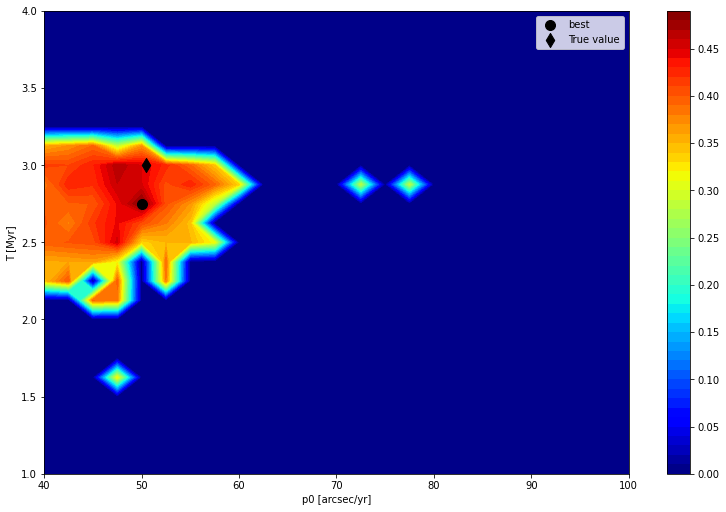

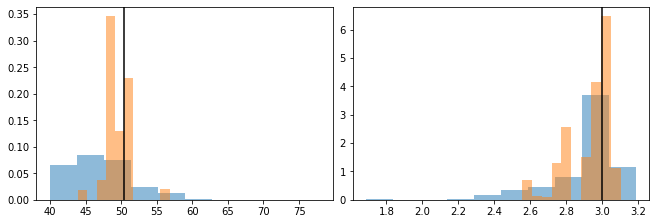

In [168]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(10,7),constrained_layout=True)
plt.contourf(p0_grid/(1/180/3600*np.pi*coef_time), T_grid/1e3, r2_grid, levels=50, cmap=plt.cm.jet)
plt.colorbar()
plt.scatter(p0_grid[j_best]/(1/180/3600*np.pi*coef_time), T_grid[i_best]/1e3, s=100, color="k", label="best")
plt.scatter(p0/(1/180/3600*np.pi*coef_time), times_true[-1]/1e3, marker="d", s=100, color="k",label="True value")
plt.legend()
# plt.ylim([0.5,1])

plt.xlabel("p0 [arcsec/yr]")
plt.ylabel("T [Myr]")

fig, axs = plt.subplots(1,2, figsize=(9,3),constrained_layout=True)
# p0_best_ensemble = np.hstack([resi.X[np.argmin(resi.F.mean(axis=1)),0] for resi in res_ensemble[:] ])
# p0_best_ensemble = np.hstack([resi.X[:,0] for resi in res_ensemble[:] ])
# F_ensemble = -np.hstack([resi.F.mean(axis=1) for resi in res_ensemble[:] ])
# asort = np.argsort(F_ensemble)
# p0_best_ensemble = p0_best_ensemble[asort]
# F_ensemble = F_ensemble[asort]
# p0_ensemble.shape
ax = axs[0]
ax.hist(p0_ensemble/arcsec_to_pi/1e3,density=True,alpha=0.5)
ax.hist(p0_ensemble[-1000:]/arcsec_to_pi/1e3,density=True, alpha=0.5)
ax.axvline(p0/arcsec_to_pi/1e3, color="black")

ax = axs[1]
ax.hist(T_ensemble/1e3,density=True,alpha=0.5)
ax.hist(T_ensemble[-1000:]/1e3,density=True, alpha=0.5)
ax.axvline(times_true[-1]/1e3, color="black")
# plt.xlim([40,60])
# plt.xlim(*p0_lims/arcsec_to_pi/1e3)
# plt.xlim([45,55])

In [112]:
n, m = 25, 25
p0_grid = np.linspace(40,60,n)
p0_grid = p0_grid*1/180/3600*np.pi*coef_time
T_grid = np.linspace(0.1, 1, m)*1e3
p0_mg, T_mg = np.meshgrid(p0_grid, T_grid)
r2_grid = np.zeros((m, n))
depth_genes = depth_genes_ensemble[0]
for res in res_ensemble:
    for i_sol in range(res.X.shape[0]):
        # res = res_ensemble[0]
        # i_sol = np.argmin(res.F.mean(axis=1))
        p0i = res.X[i_sol,0]
        reg = linear_model.LinearRegression()
        fs = np.hstack([g_k + p0i, fe_k])
        invSR_to_predx =  partial(invSR_to_pred,  data=data, invSR_lims=invSR_lims, fs=fs, interpolator=interpolator)
        time, y_pred = invSR_to_predx([depth_genes, res.X[i_sol,1:]])
        i = bisect_left(p0_grid, p0i)-1
        j = bisect_left(T_grid, time[-1,])-1
        r2_grid[j,i] = max(r2_score(y, y_pred), r2_grid[j,i])
i_best, j_best = np.where(r2_grid==r2_grid.max())


With good N_genes (=6)

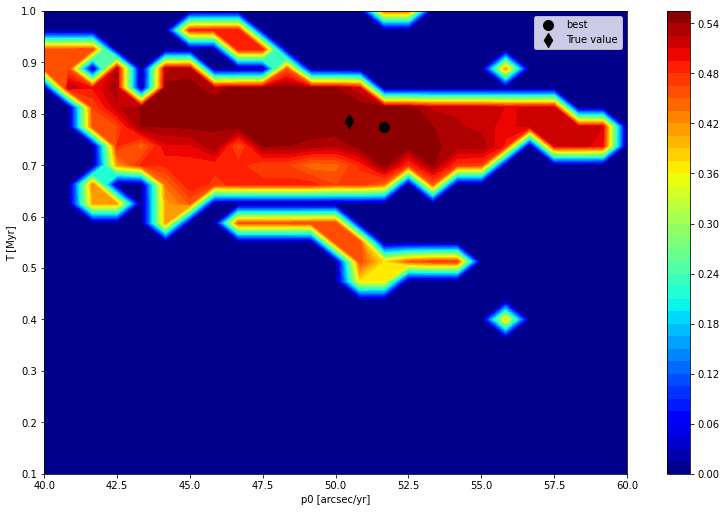

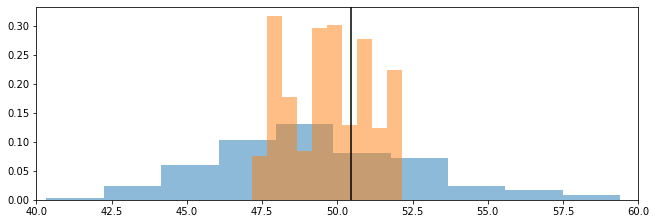

In [121]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(10,7),constrained_layout=True)
plt.contourf(p0_grid/(1/180/3600*np.pi*coef_time), T_grid/1e3, r2_grid, levels=50, cmap=plt.cm.jet)
plt.colorbar()
plt.scatter(p0_grid[j_best]/(1/180/3600*np.pi*coef_time), T_grid[i_best]/1e3, s=100, color="k", label="best")
plt.scatter(p0/(1/180/3600*np.pi*coef_time), times_true[-1]/1e3, marker="d", s=100, color="k",label="True value")
plt.legend()
# plt.ylim([0.5,1])

plt.xlabel("p0 [arcsec/yr]")
plt.ylabel("T [Myr]")

fig, ax = plt.subplots(1,1, figsize=(9,3),constrained_layout=True)
# p0_best_ensemble = np.hstack([resi.X[np.argmin(resi.F.mean(axis=1)),0] for resi in res_ensemble[:] ])
p0_best_ensemble = np.hstack([resi.X[:,0] for resi in res_ensemble[:] ])
F_ensemble = -np.hstack([resi.F.mean(axis=1) for resi in res_ensemble[:] ])
asort = np.argsort(F_ensemble)
p0_best_ensemble = p0_best_ensemble[asort]
F_ensemble = F_ensemble[asort]
# p0_ensemble.shape
plt.hist(p0_best_ensemble/arcsec_to_pi/1e3,density=True,alpha=0.5)
plt.hist(p0_best_ensemble[-500:]/arcsec_to_pi/1e3,density=True, alpha=0.5)
plt.xlim([40,60])
# plt.hist(np.hstack([resi.X[:,0] for resi in res_ensemble[:] ])/arcsec_to_pi/1e6, bins=50)
# plt.hist(np.hstack([resi.X[:,0] for resi in res_ensemble[-50:] ])/arcsec_to_pi/1e6)
plt.axvline(p0/arcsec_to_pi/1e3, color="black")
# plt.xlim(*p0_lims/arcsec_to_pi/1e3)
# plt.xlim([45,55])

With too mnay N_genes (=20)

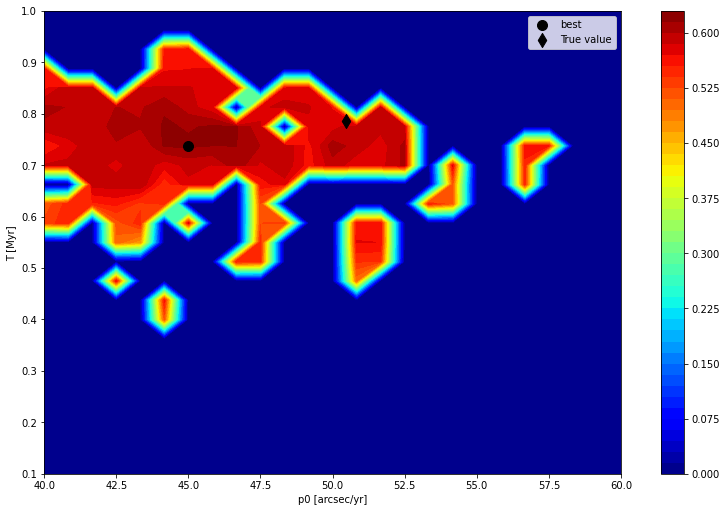

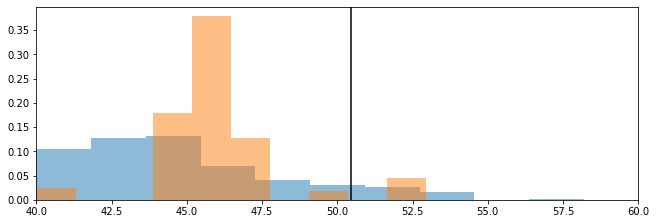

In [109]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(10,7),constrained_layout=True)
plt.contourf(p0_grid/(1/180/3600*np.pi*coef_time), T_grid/1e3, r2_grid, levels=50, cmap=plt.cm.jet)
plt.colorbar()
plt.scatter(p0_grid[j_best]/(1/180/3600*np.pi*coef_time), T_grid[i_best]/1e3, s=100, color="k", label="best")
plt.scatter(p0/(1/180/3600*np.pi*coef_time), times_true[-1]/1e3, marker="d", s=100, color="k",label="True value")
plt.legend()

plt.xlabel("p0 [arcsec/yr]")
plt.ylabel("T [Myr]")

fig, ax = plt.subplots(1,1, figsize=(9,3),constrained_layout=True)
# p0_best_ensemble = np.hstack([resi.X[np.argmin(resi.F.mean(axis=1)),0] for resi in res_ensemble[:] ])
p0_best_ensemble = np.hstack([resi.X[:,0] for resi in res_ensemble[:] ])
F_ensemble = -np.hstack([resi.F.mean(axis=1) for resi in res_ensemble[:] ])
asort = np.argsort(F_ensemble)
p0_best_ensemble = p0_best_ensemble[asort]
F_ensemble = F_ensemble[asort]
# p0_ensemble.shape
plt.hist(p0_best_ensemble/arcsec_to_pi/1e3,density=True,alpha=0.5)
plt.hist(p0_best_ensemble[-500:]/arcsec_to_pi/1e3,density=True, alpha=0.5)
plt.xlim([40,60])
# plt.hist(np.hstack([resi.X[:,0] for resi in res_ensemble[:] ])/arcsec_to_pi/1e6, bins=50)
# plt.hist(np.hstack([resi.X[:,0] for resi in res_ensemble[-50:] ])/arcsec_to_pi/1e6)
plt.axvline(p0/arcsec_to_pi/1e3, color="black")
# plt.xlim(*p0_lims/arcsec_to_pi/1e3)
# plt.xlim([45,55])

# Extract eccentricity curve

## when time is known

In [165]:
fs = np.hstack([g_k + p0, fe_k])

In [149]:
fs, fs/2/np.pi, 2*np.pi/fs

(array([0.27172399, 0.28082533, 0.32887003, 0.33150547, 0.26531565,
        0.01550968, 0.06618982, 0.05068014, 0.06355438, 0.0480447 ,
        0.00263544, 0.00640834]),
 array([0.04324622, 0.04469474, 0.05234129, 0.05276073, 0.0422263 ,
        0.00246844, 0.01053444, 0.00806599, 0.01011499, 0.00764655,
        0.00041944, 0.00101992]),
 array([  23.12341035,   22.37399749,   19.10537518,   18.95348896,
          23.68192456,  405.11381166,   94.92676503,  123.97727122,
          98.86314252,  130.7779167 , 2384.11034605,  980.47077728]))

(0.0, 0.1)

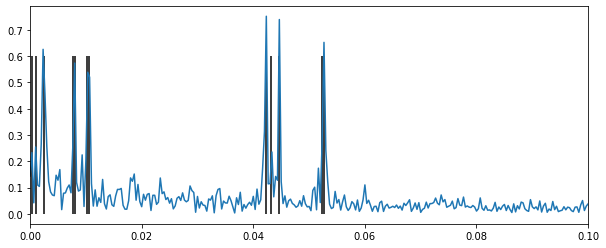

In [279]:
ydata_sp = CubicSpline(times_true, y)
times_grid = np.linspace(times_true[0], times_true[-1], len(times_true))
N = len(times_grid)
y_equ_spa = ydata_sp(times_grid)

dt = times_grid[1]-times_grid[0]
xf = sp.fft.fftfreq(N, dt)[:N//2]
yf = sp.fft.fft(y_equ_spa)

plt.figure(figsize=(10,4))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
# plt.yscale("log")
# plt.xscale("log")
plt.vlines(fs/2/np.pi, 0, 0.6, colors="black",alpha=1,zorder=-100)
plt.xlim([0,0.1])
# plt.xlim([0.04,0.06])

# plt.vlines(fs[:5]/2/np.pi, 0, 0.6, colors="orange", alpha=0.8)
# plt.xlim([0.03,0.1])
# plt.xlim([0,0.025])
# plt.xlim([50,500])
# plt.xlim([10,50])

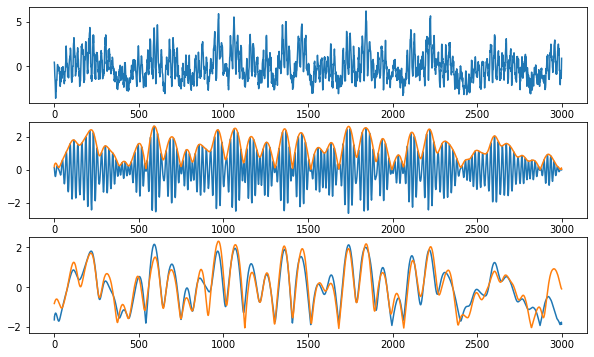

In [290]:
sos = sp.signal.butter(10, (0.04, 0.06), 'bandpass', output='sos' , fs=1/(times_grid[1]-times_grid[0]))
y_filtered = sp.signal.sosfiltfilt(sos, y_equ_spa)
complex_y = sp.signal.hilbert(y_filtered)

plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
plt.plot(times_grid, y_equ_spa)
plt.subplot(3,1,2)
plt.plot(times_grid, y_filtered)
plt.plot(times_grid, abs(complex_y))
plt.subplot(3,1,3)
y_envelope =abs(complex_y)
plt.plot(times, y_ecc)
plt.plot(times_grid, (y_envelope-y_envelope.mean())/y_envelope.std())

# filtered = signal.sosfilt(sos, sig )



## When time is not known

In [293]:
res.X.shape

(199, 21)

In [336]:
res = res_ensemble[-1]
arg_best = np.argmin(res.F.mean(axis=1))
invSR_best = res.X[arg_best, 1:]
invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
# invSR_interpolate[invSR_interpolate<invSR_lims[0]] = invSR_lims[0]
# invSR_interpolate[invSR_interpolate>invSR_lims[1]] = invSR_lims[1]
times_inferred = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
fs = np.hstack([g_k, fe_k])
fs[:5] = fs[:5]+res.X[arg_best,0]
X = generate_X_linReg(np.ones_like(fs), fs, times_inferred)
X_prec = generate_X_linReg(np.ones_like(fs[:5]), fs[:5], times_inferred)
X_ecc = generate_X_linReg(np.ones_like(fs[5:]), fs[5:], times_inferred)

reg_model = LinearRegression().fit(X, y)
AB_prec = np.hstack([reg_model.coef_[:5], reg_model.coef_[len(fs):len(fs)+5]])
AB_ecc = np.hstack([reg_model.coef_[5:len(fs)], reg_model.coef_[len(fs)+5:]])
# y_pred = reg_model.predict(X)
y_pred = X @ reg_model.coef_ 
y_pred_prec = X_prec @ AB_prec
y_pred_ecc = X_ecc @ AB_ecc

# sp.integrate.cumulative_trapezoid(invSR, depth, initial=0)

In [305]:
X.shape, reg_model.coef_ .shape, len(fs)

((3000, 24), (24,), 12)

In [311]:
y_pred - y_pred_prec-y_pred_ecc

array([ 0.00000000e+00, -2.22044605e-16,  2.22044605e-16, ...,
        5.55111512e-17,  5.55111512e-17, -2.22044605e-16])

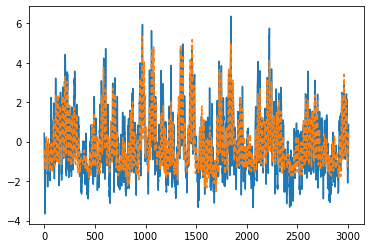

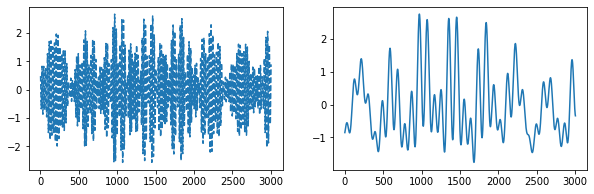

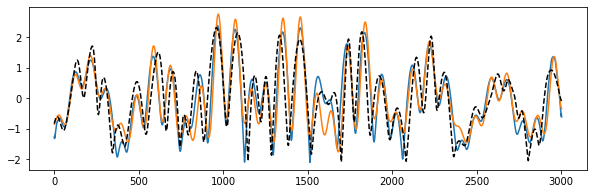

In [343]:
plt.plot(times_inferred, y)
plt.plot(times_inferred, y_pred, "--")
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(times_inferred, y_pred_prec, "--")
plt.subplot(1,2,2)
plt.plot(times_inferred, y_pred_ecc)

plt.figure(figsize=(10,3))
y_envelope = abs(sp.signal.hilbert(y_pred_prec))
y_envelope = (y_envelope-y_envelope.mean())/y_envelope.std()
plt.plot(times_inferred, y_envelope)
plt.plot(times_inferred, y_pred_ecc)
plt.plot(times_inferred, y_ecc, "--", color="black")

# plt.plot(times, y_pred_ecc, "--")